- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack


from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.layers import Conv1D,GRU,TimeDistributed,MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling1D,ZeroPadding1D

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features=scaler.fit_transform(df_features)

# Select k-best features

In [5]:
#from sklearn.feature_selection import SelectKBest,f_classif
#k=[12,15,18,21,24,31]
df_features = SelectKBest(f_classif,k=12).fit_transform(df_features,mind_wandered_label)

In [6]:
participant_ids=participant_ids[:2193]

In [7]:
#participant_ids=participant_ids[:3300]

# Allknn undersampling

In [8]:
from imblearn.under_sampling import AllKNN
#df_features=df_features.values.reshape(-1, 1)
allknn = AllKNN()
df_features, mind_wandered_label = allknn.fit_resample(df_features, mind_wandered_label)

# SMOTEENN Oversampling

In [9]:
"""from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
df_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)"""

'from imblearn.combine import SMOTEENN\nsme = SMOTEENN(random_state=42)\ndf_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)'

In [10]:
mind_wandered_label.shape

(2193,)

# Data Reshape for conv1d

In [11]:
#df_features = df_features.to_numpy()
df_features=df_features.reshape((df_features.shape[0], df_features.shape[1], 1))
df_features.shape

(2193, 12, 1)

# AUROC

In [12]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

# Conv1d Model

A **ZeroPadding1D** layer is added after the input layer to add zeros at the beginning and end of each series. Zero-padding ensures that the convolution layer does not reduce the dimension of the output sequences.

We add a Conv1D layer. The first argument of Conv1D is the number of filters, which determine the number of features in the output. The second argument indicates the length of the 1D convolution window. The third argument is strides and represents the number of places to shift the convolution window. Lastly, though we haven't used it here, setting use_bias as True adds a bias value during the computation of an output feature. Here, the 1D convolution can be thought of as generating local MW models over a rolling window of Five time units.

From tensorflow doc: 

Padding: One of "valid", "same" or "causal" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input. "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order

In [13]:
def create_model(filters=64,kernel_size=5):
    model = Sequential([
    Conv1D(filters=filters, kernel_size=kernel_size,strides=8, activation='tanh',padding='same', input_shape=(df_features.shape[1], 1)),
    ZeroPadding1D(padding=1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
    optimizer=SGD(lr=0.001)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', auc_roc])
    return model

In [14]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=50, batch_size=32, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [15]:

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None


parameters = {
        #'scaling__type_of_scaling': ['standard'],
        #'outlier__outlier_threshold': [0.0, 3.0],
        #'features__k': [12,15],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        'model__batch_size': [32, 48],#usually multiple of 8
        'model__epochs':[50,60],
        'model__filters':[8,16,32,64],
        'model__kernel_size':[3,5,7],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

# Estimator Pipeline
pipeline = Pipeline(
      [
        #('progress', GridSearchProgressHack(verbose=False)),
        #('scaling',  FeatureScalerTransformer()),
        #('outlier',  WinsorizationOutlierTransformer()),
        #('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        #('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
# Cross Validation Splitter
cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        #cv = 5,
        refit = 'roc_auc',
        verbose = 1)

search.fit(df_features, mind_wandered_label, groups=participant_ids)
#search.fit(df_features, mind_wandered_label)

df = pd.DataFrame(data=search.cv_results_)
    
    
if best_estimator is None:
    df_result = df
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_
    best_index = search.best_index_
else:
    df_result = df_result.append(df, ignore_index=True)
    if search.best_score_ > best_score:
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_  # todo this is only the index of this search

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.7105 - accuracy: 0.4035 - auc_roc: 0.3397
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.4359 - auc_roc: 0.3702
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.4315 - auc_roc: 0.3790
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.4266 - auc_roc: 0.3726
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.4238 - auc_roc: 0.3759
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7087 - accuracy: 0.4157 - auc_roc: 0.3573
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7070 - accuracy: 0.4247 - auc_roc: 0.3673
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7069 - accuracy: 0.4173 - auc_roc: 0.3648
Epoch 9/50

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 3ms/step - loss: 0.6812 - accuracy: 0.5318 - auc_roc: 0.4791
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5586 - auc_roc: 0.6406
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5670 - auc_roc: 0.6399
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5724 - auc_roc: 0.6547
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5989 - auc_roc: 0.6531
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.5747 - auc_roc: 0.6335
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.6184 - auc_roc: 0.6686
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.6208 - auc_roc: 0.6582
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6882 - accuracy: 0.5450 - auc_roc: 0.6796
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5448 - auc_roc: 0.5433
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5787 - auc_roc: 0.5970
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5710 - auc_roc: 0.5786
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5725 - auc_roc: 0.5826
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5606 - auc_roc: 0.5734
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5732 - auc_roc: 0.5855
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5905 - auc_roc: 0.6072
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6789 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6964 - accuracy: 0.4139 - auc_roc: 0.6427
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.4374 - auc_roc: 0.4948
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4494 - auc_roc: 0.4719
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4397 - auc_roc: 0.4750
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4422 - auc_roc: 0.4781
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.4587 - auc_roc: 0.4952
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.4578 - auc_roc: 0.4990
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4368 - auc_roc: 0.4706
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6982 - accuracy: 0.4270 - auc_roc: 0.5713
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.4486 - auc_roc: 0.4270
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4600 - auc_roc: 0.4364
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6966 - accuracy: 0.4586 - auc_roc: 0.4365
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.4670 - auc_roc: 0.4517
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4951 - auc_roc: 0.4893
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.4644 - auc_roc: 0.4374
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4975 - auc_roc: 0.4803
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.5613 - auc_roc: 0.6597
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5578 - auc_roc: 0.6181
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5680 - auc_roc: 0.6355
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5689 - auc_roc: 0.6315
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5483 - auc_roc: 0.6000
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5909 - auc_roc: 0.6415
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5725 - auc_roc: 0.6393
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5748 - auc_roc: 0.6354
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6764 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6966 - accuracy: 0.5100 - auc_roc: 0.6437
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5124 - auc_roc: 0.4668
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5206 - auc_roc: 0.4778
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5194 - auc_roc: 0.4812
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5110 - auc_roc: 0.4718
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5125 - auc_roc: 0.4681
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5757 - auc_roc: 0.5183
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5350 - auc_roc: 0.5027
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6948 - accuracy: 0.5036 - auc_roc: 0.6213
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5110 - auc_roc: 0.5260
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5254 - auc_roc: 0.5417
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5383 - auc_roc: 0.5610
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5134 - auc_roc: 0.5428
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5235 - auc_roc: 0.5230
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5265 - auc_roc: 0.5539
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5422 - auc_roc: 0.5683
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6940 - accuracy: 0.5047 - auc_roc: 0.6207
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5166 - auc_roc: 0.5119
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5176 - auc_roc: 0.5159
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5068 - auc_roc: 0.4994
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5050 - auc_roc: 0.4969
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5161 - auc_roc: 0.5117
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5330 - auc_roc: 0.5174
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5261 - auc_roc: 0.5195
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6910 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7003 - accuracy: 0.4664 - auc_roc: 0.5851
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4587 - auc_roc: 0.4221
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.4743 - auc_roc: 0.4168
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.4467 - auc_roc: 0.3997
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.4616 - auc_roc: 0.4214
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.4816 - auc_roc: 0.4331
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4794 - auc_roc: 0.4269
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.4621 - auc_roc: 0.4288
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6974 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6716 - accuracy: 0.6060 - auc_roc: 0.5900
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.6379 - auc_roc: 0.7177
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6341 - auc_roc: 0.6773
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6226 - auc_roc: 0.6758
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6415 - auc_roc: 0.6976
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6462 - auc_roc: 0.7076
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6236 - auc_roc: 0.6993
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6652 - accuracy: 0.6219 - auc_roc: 0.6912
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6635 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6834 - accuracy: 0.6045 - auc_roc: 0.6975
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.6009 - auc_roc: 0.6308
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.6236 - auc_roc: 0.6575
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6254 - auc_roc: 0.6451
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.6042 - auc_roc: 0.6422
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.6016 - auc_roc: 0.6449
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.6276 - auc_roc: 0.6605
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.6222 - auc_roc: 0.6507
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6765 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6843 - accuracy: 0.6107 - auc_roc: 0.7040
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.6071 - auc_roc: 0.6228
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.6300 - auc_roc: 0.6584
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.6196 - auc_roc: 0.6528
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.6194 - auc_roc: 0.6554
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.6119 - auc_roc: 0.6292
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.6030 - auc_roc: 0.6395
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.6205 - auc_roc: 0.6571
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6787 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7040 - accuracy: 0.3866 - auc_roc: 0.6312
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.4076 - auc_roc: 0.3533
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.4038 - auc_roc: 0.3395
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.4083 - auc_roc: 0.3511
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.4142 - auc_roc: 0.3574
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.4063 - auc_roc: 0.3534
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.4326 - auc_roc: 0.3759
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4376 - auc_roc: 0.3860
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6991 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7022 - accuracy: 0.4498 - auc_roc: 0.5408
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.4490 - auc_roc: 0.3968
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.4605 - auc_roc: 0.4145
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.4468 - auc_roc: 0.4202
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.4666 - auc_roc: 0.4173
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.4506 - auc_roc: 0.4190
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.4488 - auc_roc: 0.4142
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.4524 - auc_roc: 0.4410
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7008 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6940 - accuracy: 0.4990 - auc_roc: 0.5680
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.4957 - auc_roc: 0.4646
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.4906 - auc_roc: 0.4613
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.5185 - auc_roc: 0.4913
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6957 - accuracy: 0.4753 - auc_roc: 0.4510
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.4880 - auc_roc: 0.4618
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5101 - auc_roc: 0.4977
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5232 - auc_roc: 0.5065
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6916 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.6235 - auc_roc: 0.6531
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.6388 - auc_roc: 0.7006
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.6178 - auc_roc: 0.6800
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6765 - accuracy: 0.6516 - auc_roc: 0.7001
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.6527 - auc_roc: 0.6913
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.6404 - auc_roc: 0.6920
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6760 - accuracy: 0.6403 - auc_roc: 0.6910
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6759 - accuracy: 0.6379 - auc_roc: 0.6976
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6743 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7055 - accuracy: 0.4344 - auc_roc: 0.6504
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.4490 - auc_roc: 0.4175
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.4309 - auc_roc: 0.3827
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7044 - accuracy: 0.4503 - auc_roc: 0.4060
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.4359 - auc_roc: 0.3942
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7044 - accuracy: 0.4509 - auc_roc: 0.4060
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7048 - accuracy: 0.4486 - auc_roc: 0.3959
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.4687 - auc_roc: 0.4432
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7019 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6779 - accuracy: 0.5422 - auc_roc: 0.5847
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6759 - accuracy: 0.5454 - auc_roc: 0.6548
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.5634 - auc_roc: 0.6559
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.5891 - auc_roc: 0.6855
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5892 - auc_roc: 0.6787
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.5946 - auc_roc: 0.6807
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.6045 - auc_roc: 0.6871
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5879 - auc_roc: 0.6688
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6685 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6977 - accuracy: 0.4688 - auc_roc: 0.6551
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.4588 - auc_roc: 0.4362
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.4838 - auc_roc: 0.4529
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.4612 - auc_roc: 0.4358
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.4852 - auc_roc: 0.4547
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.4975 - auc_roc: 0.4829
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.5093 - auc_roc: 0.4923
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.5172 - auc_roc: 0.4923
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6944 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 2ms/step - loss: 0.6982 - accuracy: 0.5003 - auc_roc: 0.5923
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5111 - auc_roc: 0.4598
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.5262 - auc_roc: 0.4649
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.4844 - auc_roc: 0.4372
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.5024 - auc_roc: 0.4477
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.5003 - auc_roc: 0.4474
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.5143 - auc_roc: 0.4875
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6979 - accuracy: 0.5014 - auc_roc: 0.4722
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6971 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 2ms/step - loss: 0.6960 - accuracy: 0.4847 - auc_roc: 0.5961
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.4723 - auc_roc: 0.4325
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.5006 - auc_roc: 0.4425
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.5033 - auc_roc: 0.4520
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.5118 - auc_roc: 0.4586
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5035 - auc_roc: 0.4654
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5370 - auc_roc: 0.4759
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5162 - auc_roc: 0.4803
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6931 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7096 - accuracy: 0.3688 - auc_roc: 0.5508
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7112 - accuracy: 0.3496 - auc_roc: 0.2800
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7123 - accuracy: 0.3426 - auc_roc: 0.2646
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7108 - accuracy: 0.3490 - auc_roc: 0.2947
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.3666 - auc_roc: 0.2952
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7100 - accuracy: 0.3577 - auc_roc: 0.3021
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.3642 - auc_roc: 0.2892
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.3612 - auc_roc: 0.2887
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7098 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 3ms/step - loss: 0.6972 - accuracy: 0.4666 - auc_roc: 0.5304
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4520 - auc_roc: 0.4600
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.4841 - auc_roc: 0.4923
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5130 - auc_roc: 0.5201
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.4984 - auc_roc: 0.4917
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5020 - auc_roc: 0.4971
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5019 - auc_roc: 0.5058
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5355 - auc_roc: 0.5326
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6902 - accuracy: 0.5759 - auc_roc: 0.6615
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5746 - auc_roc: 0.5858
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5808 - auc_roc: 0.5905
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5636 - auc_roc: 0.5659
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5659 - auc_roc: 0.5902
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5683 - auc_roc: 0.5873
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5775 - auc_roc: 0.5969
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5895 - auc_roc: 0.5999
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6888 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.4852 - auc_roc: 0.6616
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5098 - auc_roc: 0.5196
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4869 - auc_roc: 0.5136
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4948 - auc_roc: 0.5192
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5069 - auc_roc: 0.5494
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4854 - auc_roc: 0.5181
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5069 - auc_roc: 0.5418
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.4962 - auc_roc: 0.5558
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6817 - accuracy: 0.5159 - auc_roc: 0.6817
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5295 - auc_roc: 0.7085
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5370 - auc_roc: 0.6637
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5570 - auc_roc: 0.7133
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5539 - auc_roc: 0.6806
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5559 - auc_roc: 0.7274
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5604 - auc_roc: 0.6997
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5714 - auc_roc: 0.6903
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6713 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6977 - accuracy: 0.4506 - auc_roc: 0.6666
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.4645 - auc_roc: 0.4391
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.4724 - auc_roc: 0.4358
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.4822 - auc_roc: 0.4415
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.4768 - auc_roc: 0.4459
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4795 - auc_roc: 0.4710
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.4800 - auc_roc: 0.4493
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5066 - auc_roc: 0.4872
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7015 - accuracy: 0.5147 - auc_roc: 0.6434
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5320 - auc_roc: 0.4217
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5365 - auc_roc: 0.4130
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5437 - auc_roc: 0.4265
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5258 - auc_roc: 0.4335
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5472 - auc_roc: 0.4483
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5620 - auc_roc: 0.4716
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5620 - auc_roc: 0.4723
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6972 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7102 - accuracy: 0.3935 - auc_roc: 0.5942
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.4049 - auc_roc: 0.3731
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.3955 - auc_roc: 0.3743
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.4019 - auc_roc: 0.3723
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.4080 - auc_roc: 0.3835
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.4165 - auc_roc: 0.3856
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.4343 - auc_roc: 0.4215
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.4380 - auc_roc: 0.4319
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7060 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 3ms/step - loss: 0.7041 - accuracy: 0.4463 - auc_roc: 0.5784
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.4405 - auc_roc: 0.3615
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.4552 - auc_roc: 0.3618
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.4707 - auc_roc: 0.3923
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.4762 - auc_roc: 0.3525
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.4697 - auc_roc: 0.3872
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.4729 - auc_roc: 0.3992
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.4645 - auc_roc: 0.3844
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6973 - accuracy: 0.4597 - auc_roc: 0.6247
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4700 - auc_roc: 0.4489
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.4812 - auc_roc: 0.4662
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4851 - auc_roc: 0.4760
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5042 - auc_roc: 0.4906
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5182 - auc_roc: 0.5102
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5118 - auc_roc: 0.5004
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5378 - auc_roc: 0.5364
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.5615 - auc_roc: 0.6961
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5642 - auc_roc: 0.5808
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5797 - auc_roc: 0.5862
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5793 - auc_roc: 0.5900
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5866 - auc_roc: 0.6073
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5536 - auc_roc: 0.5845
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5761 - auc_roc: 0.5899
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5685 - auc_roc: 0.5900
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6830 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6972 - accuracy: 0.4474 - auc_roc: 0.6583
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4708 - auc_roc: 0.4654
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4732 - auc_roc: 0.4609
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4876 - auc_roc: 0.4800
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5046 - auc_roc: 0.5001
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5172 - auc_roc: 0.5096
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5230 - auc_roc: 0.5142
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5334 - auc_roc: 0.5280
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7122 - accuracy: 0.3849 - auc_roc: 0.6078
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.3657 - auc_roc: 0.3152
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.3783 - auc_roc: 0.3296
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.3814 - auc_roc: 0.3272
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.3876 - auc_roc: 0.3220
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.3941 - auc_roc: 0.3383
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.3838 - auc_roc: 0.3234
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.3801 - auc_roc: 0.3424
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7048 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6869 - accuracy: 0.5292 - auc_roc: 0.6143
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5438 - auc_roc: 0.5667
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5279 - auc_roc: 0.5822
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5449 - auc_roc: 0.5872
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5256 - auc_roc: 0.5766
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5248 - auc_roc: 0.5853
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5408 - auc_roc: 0.5974
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5190 - auc_roc: 0.5854
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6819 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7047 - accuracy: 0.3725 - auc_roc: 0.6116
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.3847 - auc_roc: 0.3551
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.4006 - auc_roc: 0.3727
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.3918 - auc_roc: 0.3841
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.4017 - auc_roc: 0.3729
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.4202 - auc_roc: 0.3836
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.4098 - auc_roc: 0.3713
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.4022 - auc_roc: 0.3735
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6994 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5624 - auc_roc: 0.6629
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5676 - auc_roc: 0.6031
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5679 - auc_roc: 0.6169
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5719 - auc_roc: 0.6279
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5892 - auc_roc: 0.6351
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5783 - auc_roc: 0.6428
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5873 - auc_roc: 0.6335
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.6195 - auc_roc: 0.6739
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6841 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6885 - accuracy: 0.5257 - auc_roc: 0.7027
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5353 - auc_roc: 0.5506
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5468 - auc_roc: 0.5635
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5626 - auc_roc: 0.5773
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5795 - auc_roc: 0.5954
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5764 - auc_roc: 0.5730
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5688 - auc_roc: 0.5846
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5756 - auc_roc: 0.5872
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6825 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6983 - accuracy: 0.4152 - auc_roc: 0.6282
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.4315 - auc_roc: 0.4361
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.4418 - auc_roc: 0.4140
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4362 - auc_roc: 0.4294
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.4333 - auc_roc: 0.4320
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4517 - auc_roc: 0.4345
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4605 - auc_roc: 0.4615
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.4530 - auc_roc: 0.4444
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6940 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6974 - accuracy: 0.4626 - auc_roc: 0.6315
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4808 - auc_roc: 0.4553
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.4605 - auc_roc: 0.4436
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.4944 - auc_roc: 0.4782
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5007 - auc_roc: 0.4953
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5206 - auc_roc: 0.5187
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5081 - auc_roc: 0.5086
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5412 - auc_roc: 0.5501
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6869 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7024 - accuracy: 0.3861 - auc_roc: 0.6532
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.4108 - auc_roc: 0.4140
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.4136 - auc_roc: 0.4179
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.4086 - auc_roc: 0.4123
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.4245 - auc_roc: 0.4369
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.4268 - auc_roc: 0.4405
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.4318 - auc_roc: 0.4358
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.4314 - auc_roc: 0.4399
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6975 - accuracy: 0.5698 - auc_roc: 0.6134
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5720 - auc_roc: 0.5379
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.5790 - auc_roc: 0.5413
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5905 - auc_roc: 0.5632
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5937 - auc_roc: 0.5639
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5845 - auc_roc: 0.5684
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5924 - auc_roc: 0.5728
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.6007 - auc_roc: 0.5808
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7160 - accuracy: 0.3333 - auc_roc: 0.6108
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.3320 - auc_roc: 0.3038
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.3188 - auc_roc: 0.2935
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.3273 - auc_roc: 0.2807
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.3516 - auc_roc: 0.3128
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.3380 - auc_roc: 0.3026
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.3545 - auc_roc: 0.3148
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.3703 - auc_roc: 0.3203
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7069 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6838 - accuracy: 0.6060 - auc_roc: 0.6839
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.6052 - auc_roc: 0.6559
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.6099 - auc_roc: 0.6551
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5970 - auc_roc: 0.6429
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6186 - auc_roc: 0.6757
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.6341 - auc_roc: 0.6897
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.6402 - auc_roc: 0.6796
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.6427 - auc_roc: 0.6891
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6786 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6987 - accuracy: 0.4488 - auc_roc: 0.6546
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4521 - auc_roc: 0.4313
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.4598 - auc_roc: 0.4311
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.4579 - auc_roc: 0.4397
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.4481 - auc_roc: 0.4383
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4574 - auc_roc: 0.4395
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.4529 - auc_roc: 0.4484
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.4894 - auc_roc: 0.4776
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6971 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.4863 - auc_roc: 0.6585
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5023 - auc_roc: 0.5507
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5128 - auc_roc: 0.5731
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5355 - auc_roc: 0.5972
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5446 - auc_roc: 0.6031
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5308 - auc_roc: 0.5753
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5296 - auc_roc: 0.6111
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5192 - auc_roc: 0.6017
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6863 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6977 - accuracy: 0.4766 - auc_roc: 0.6577
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4914 - auc_roc: 0.3733
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.4992 - auc_roc: 0.3684
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5073 - auc_roc: 0.4020
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5058 - auc_roc: 0.4219
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4901 - auc_roc: 0.4340
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5035 - auc_roc: 0.4366
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.4991 - auc_roc: 0.4457
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6995 - accuracy: 0.5066 - auc_roc: 0.6461
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5211 - auc_roc: 0.3979
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5213 - auc_roc: 0.3992
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.5420 - auc_roc: 0.4235
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5381 - auc_roc: 0.4227
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5694 - auc_roc: 0.4365
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5492 - auc_roc: 0.4435
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5633 - auc_roc: 0.4416
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6953 - accuracy: 0.5109 - auc_roc: 0.6587
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5112 - auc_roc: 0.5313
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5071 - auc_roc: 0.5297
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5496 - auc_roc: 0.5383
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5343 - auc_roc: 0.5546
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5455 - auc_roc: 0.5629
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5305 - auc_roc: 0.5535
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5469 - auc_roc: 0.5678
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6951 - accuracy: 0.4805 - auc_roc: 0.6531
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4932 - auc_roc: 0.4945
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5097 - auc_roc: 0.5053
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5029 - auc_roc: 0.4988
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5164 - auc_roc: 0.5207
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5277 - auc_roc: 0.5329
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5326 - auc_roc: 0.5481
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5647 - auc_roc: 0.5690
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6900 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6909 - accuracy: 0.5682 - auc_roc: 0.6622
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5710 - auc_roc: 0.5694
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5594 - auc_roc: 0.5567
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5683 - auc_roc: 0.5951
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.6012 - auc_roc: 0.5940
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5919 - auc_roc: 0.6047
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.6197 - auc_roc: 0.6112
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.6149 - auc_roc: 0.6192
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6867 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6946 - accuracy: 0.5204 - auc_roc: 0.6646
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5173 - auc_roc: 0.4564
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5402 - auc_roc: 0.5139
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5352 - auc_roc: 0.5014
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5294 - auc_roc: 0.5526
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5417 - auc_roc: 0.5352
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5359 - auc_roc: 0.5497
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5429 - auc_roc: 0.5980
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6853 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.5203 - auc_roc: 0.6577
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5288 - auc_roc: 0.4457
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5445 - auc_roc: 0.4665
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5110 - auc_roc: 0.4912
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5180 - auc_roc: 0.4971
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5424 - auc_roc: 0.5312
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5339 - auc_roc: 0.5130
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5323 - auc_roc: 0.5380
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7030 - accuracy: 0.3812 - auc_roc: 0.6322
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.3838 - auc_roc: 0.3213
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.3969 - auc_roc: 0.3266
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.4103 - auc_roc: 0.3552
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.4114 - auc_roc: 0.3508
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.3830 - auc_roc: 0.3307
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.4087 - auc_roc: 0.3597
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.3923 - auc_roc: 0.3384
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7000 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 546us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7098 - accuracy: 0.3752 - auc_roc: 0.5222
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.4101 - auc_roc: 0.3695
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.4038 - auc_roc: 0.3322
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.4155 - auc_roc: 0.3670
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.4363 - auc_roc: 0.3898
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.4321 - auc_roc: 0.3843
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.4513 - auc_roc: 0.4134
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.4527 - auc_roc: 0.4056
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6886 - accuracy: 0.6121 - auc_roc: 0.7286
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.6247 - auc_roc: 0.6170
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.6345 - auc_roc: 0.6445
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.6248 - auc_roc: 0.6331
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.6475 - auc_roc: 0.6750
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.6328 - auc_roc: 0.6638
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.6356 - auc_roc: 0.6720
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.6359 - auc_roc: 0.6818
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6824 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6909 - accuracy: 0.4956 - auc_roc: 0.7108
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5127 - auc_roc: 0.5591
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5206 - auc_roc: 0.5694
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5264 - auc_roc: 0.5762
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5434 - auc_roc: 0.5857
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5382 - auc_roc: 0.5995
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5496 - auc_roc: 0.5996
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5688 - auc_roc: 0.6307
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6824 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6968 - accuracy: 0.4214 - auc_roc: 0.6738
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.4586 - auc_roc: 0.4559
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.4557 - auc_roc: 0.4677
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4690 - auc_roc: 0.4845
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.4717 - auc_roc: 0.5132
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.4953 - auc_roc: 0.5484
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5012 - auc_roc: 0.5698
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5145 - auc_roc: 0.5839
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6888 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6958 - accuracy: 0.4700 - auc_roc: 0.7034
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.4622 - auc_roc: 0.5100
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4960 - auc_roc: 0.5106
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5024 - auc_roc: 0.5262
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5012 - auc_roc: 0.5401
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5102 - auc_roc: 0.5461
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5128 - auc_roc: 0.5768
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5100 - auc_roc: 0.5826
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6814 - accuracy: 0.5979 - auc_roc: 0.7055
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.6079 - auc_roc: 0.6556
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.6081 - auc_roc: 0.6618
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5917 - auc_roc: 0.6351
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.6135 - auc_roc: 0.6508
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.6079 - auc_roc: 0.6509
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.6143 - auc_roc: 0.6390
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.6172 - auc_roc: 0.6624
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6824 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7086 - accuracy: 0.3678 - auc_roc: 0.6141
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.3666 - auc_roc: 0.3303
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.3866 - auc_roc: 0.3532
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.3612 - auc_roc: 0.3233
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.3805 - auc_roc: 0.3493
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.3981 - auc_roc: 0.3648
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.4097 - auc_roc: 0.3737
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.3759 - auc_roc: 0.3311
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7067 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7034 - accuracy: 0.4872 - auc_roc: 0.5538
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.4934 - auc_roc: 0.4425
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5066 - auc_roc: 0.4595
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.4949 - auc_roc: 0.4586
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.4970 - auc_roc: 0.4488
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.4929 - auc_roc: 0.4433
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.4872 - auc_roc: 0.4495
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.4900 - auc_roc: 0.4493
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7010 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7019 - accuracy: 0.3988 - auc_roc: 0.5469
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.4041 - auc_roc: 0.3478
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.3993 - auc_roc: 0.3685
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.4070 - auc_roc: 0.3648
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4330 - auc_roc: 0.3953
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.4139 - auc_roc: 0.3546
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.4200 - auc_roc: 0.3586
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.4496 - auc_roc: 0.3995
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6905 - accuracy: 0.4989 - auc_roc: 0.5583
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5049 - auc_roc: 0.5116
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.4951 - auc_roc: 0.5026
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5256 - auc_roc: 0.5357
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5264 - auc_roc: 0.5377
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4816 - auc_roc: 0.5014
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5267 - auc_roc: 0.5345
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5156 - auc_roc: 0.5147
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6874 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6955 - accuracy: 0.4810 - auc_roc: 0.5832
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.4826 - auc_roc: 0.4833
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5179 - auc_roc: 0.5171
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.4883 - auc_roc: 0.4982
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.4789 - auc_roc: 0.5129
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4902 - auc_roc: 0.4908
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5042 - auc_roc: 0.5309
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.4961 - auc_roc: 0.5137
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6886 - accuracy: 0.4783 - auc_roc: 0.6569
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.4730 - auc_roc: 0.5615
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5046 - auc_roc: 0.5829
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.4956 - auc_roc: 0.5580
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5245 - auc_roc: 0.5589
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.4943 - auc_roc: 0.5807
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5215 - auc_roc: 0.5962
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5007 - auc_roc: 0.5779
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6894 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6808 - accuracy: 0.5916 - auc_roc: 0.6453
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5712 - auc_roc: 0.6464
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5853 - auc_roc: 0.6576
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5646 - auc_roc: 0.6357
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.6060 - auc_roc: 0.6720
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5883 - auc_roc: 0.6647
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5870 - auc_roc: 0.6461
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5985 - auc_roc: 0.6598
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6758 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6957 - accuracy: 0.4473 - auc_roc: 0.6487
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.4285 - auc_roc: 0.4165
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.4489 - auc_roc: 0.4333
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.4793 - auc_roc: 0.4513
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4921 - auc_roc: 0.4762
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4778 - auc_roc: 0.4535
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5170 - auc_roc: 0.4956
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5272 - auc_roc: 0.4982
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6926 - accuracy: 0.5351 - auc_roc: 0.6426
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5327 - auc_roc: 0.5238
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5307 - auc_roc: 0.5334
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5099 - auc_roc: 0.4941
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5361 - auc_roc: 0.5225
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5427 - auc_roc: 0.5357
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5398 - auc_roc: 0.5445
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5626 - auc_roc: 0.5511
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6923 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6948 - accuracy: 0.4841 - auc_roc: 0.5949
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4975 - auc_roc: 0.4936
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.4881 - auc_roc: 0.4836
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5259 - auc_roc: 0.5248
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5093 - auc_roc: 0.5065
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5069 - auc_roc: 0.5121
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5247 - auc_roc: 0.5252
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5342 - auc_roc: 0.5439
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7038 - accuracy: 0.4611 - auc_roc: 0.6606
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.4743 - auc_roc: 0.4810
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.4686 - auc_roc: 0.4715
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.4939 - auc_roc: 0.5014
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4986 - auc_roc: 0.5078
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.4920 - auc_roc: 0.5050
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.4836 - auc_roc: 0.5050
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.4917 - auc_roc: 0.5033
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6897 - accuracy: 0.5313 - auc_roc: 0.6455
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4970 - auc_roc: 0.5795
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5061 - auc_roc: 0.5938
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5341 - auc_roc: 0.5953
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5526 - auc_roc: 0.6077
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5310 - auc_roc: 0.6242
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5458 - auc_roc: 0.6278
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5443 - auc_roc: 0.6322
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6862 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7114 - accuracy: 0.3661 - auc_roc: 0.6488
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.3959 - auc_roc: 0.3709
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.3934 - auc_roc: 0.3736
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.3802 - auc_roc: 0.3601
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.3825 - auc_roc: 0.3588
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.3954 - auc_roc: 0.3857
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.3999 - auc_roc: 0.3819
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.4152 - auc_roc: 0.4084
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7030 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7019 - accuracy: 0.4092 - auc_roc: 0.5765
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.4253 - auc_roc: 0.3918
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.4366 - auc_roc: 0.4075
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.4223 - auc_roc: 0.3848
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.4529 - auc_roc: 0.4240
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.4419 - auc_roc: 0.4209
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.4350 - auc_roc: 0.4088
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4380 - auc_roc: 0.4156
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6985 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7078 - accuracy: 0.4200 - auc_roc: 0.5582
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.4237 - auc_roc: 0.3810
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.4198 - auc_roc: 0.3716
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.4051 - auc_roc: 0.3659
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.3992 - auc_roc: 0.3537
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.4132 - auc_roc: 0.3772
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.4075 - auc_roc: 0.3694
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.4071 - auc_roc: 0.3727
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7048 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6954 - accuracy: 0.5049 - auc_roc: 0.5524
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5277 - auc_roc: 0.4974
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5403 - auc_roc: 0.4902
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5242 - auc_roc: 0.5017
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5371 - auc_roc: 0.5122
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5337 - auc_roc: 0.4949
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5319 - auc_roc: 0.5135
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5214 - auc_roc: 0.5010
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6926 - accuracy: 0.5360 - auc_roc: 0.5819
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5190 - auc_roc: 0.5122
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5235 - auc_roc: 0.4813
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5583 - auc_roc: 0.5354
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5348 - auc_roc: 0.4915
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5368 - auc_roc: 0.4958
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5479 - auc_roc: 0.5147
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5702 - auc_roc: 0.5416
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6870 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6984 - accuracy: 0.5380 - auc_roc: 0.6258
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5401 - auc_roc: 0.4216
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5340 - auc_roc: 0.4141
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5127 - auc_roc: 0.4220
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.5242 - auc_roc: 0.4228
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5370 - auc_roc: 0.4382
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5143 - auc_roc: 0.4276
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5405 - auc_roc: 0.4495
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6974 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6944 - accuracy: 0.5078 - auc_roc: 0.5692
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5046 - auc_roc: 0.4866
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5250 - auc_roc: 0.5217
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5086 - auc_roc: 0.4939
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5270 - auc_roc: 0.5196
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5163 - auc_roc: 0.5098
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5191 - auc_roc: 0.5227
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5238 - auc_roc: 0.5251
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6987 - accuracy: 0.4138 - auc_roc: 0.5989
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.3991 - auc_roc: 0.3688
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.4198 - auc_roc: 0.4023
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.4256 - auc_roc: 0.4239
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.4125 - auc_roc: 0.4035
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.4380 - auc_roc: 0.4298
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.4414 - auc_roc: 0.4279
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.4337 - auc_roc: 0.4298
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7001 - accuracy: 0.4493 - auc_roc: 0.5898
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4720 - auc_roc: 0.3944
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4888 - auc_roc: 0.4081
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5026 - auc_roc: 0.4158
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.4840 - auc_roc: 0.3864
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.4903 - auc_roc: 0.4294
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.4977 - auc_roc: 0.4325
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4796 - auc_roc: 0.4086
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.4602 - auc_roc: 0.6295
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4683 - auc_roc: 0.4783
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4641 - auc_roc: 0.4786
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4590 - auc_roc: 0.4825
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4692 - auc_roc: 0.4891
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5053 - auc_roc: 0.5324
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5004 - auc_roc: 0.5376
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5078 - auc_roc: 0.5344
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6889 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.4349 - auc_roc: 0.6844
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4547 - auc_roc: 0.5173
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.4705 - auc_roc: 0.5308
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.4494 - auc_roc: 0.5132
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4432 - auc_roc: 0.5193
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4565 - auc_roc: 0.5236
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.4745 - auc_roc: 0.5433
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.4764 - auc_roc: 0.5423
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6830 - accuracy: 0.5948 - auc_roc: 0.6661
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.6136 - auc_roc: 0.6453
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.6189 - auc_roc: 0.6747
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.6228 - auc_roc: 0.6517
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5977 - auc_roc: 0.6377
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.6235 - auc_roc: 0.6583
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.6332 - auc_roc: 0.6709
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.6336 - auc_roc: 0.6662
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6770 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6843 - accuracy: 0.6263 - auc_roc: 0.6922
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.6426 - auc_roc: 0.6895
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.6617 - auc_roc: 0.7195
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.6466 - auc_roc: 0.7051
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.6712 - auc_roc: 0.7439
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.6740 - auc_roc: 0.7449
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.6800 - auc_roc: 0.7365
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.7045 - auc_roc: 0.7454
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6748 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6923 - accuracy: 0.5380 - auc_roc: 0.7012
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5730 - auc_roc: 0.5703
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5551 - auc_roc: 0.5529
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5771 - auc_roc: 0.5590
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5823 - auc_roc: 0.5825
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5853 - auc_roc: 0.5689
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5976 - auc_roc: 0.5986
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.6021 - auc_roc: 0.6033
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6873 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7050 - accuracy: 0.4237 - auc_roc: 0.6315
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.4132 - auc_roc: 0.3485
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.4247 - auc_roc: 0.3708
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.4167 - auc_roc: 0.3484
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.4422 - auc_roc: 0.3750
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.4174 - auc_roc: 0.3724
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.4269 - auc_roc: 0.3906
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.4517 - auc_roc: 0.3948
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7023 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 606us/step
Epoch 1/60


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6730 - accuracy: 0.6444 - auc_roc: 0.7394
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.6410 - auc_roc: 0.6940
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.6490 - auc_roc: 0.7032
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6482 - auc_roc: 0.7110
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6594 - auc_roc: 0.7185
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6617 - auc_roc: 0.7263
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.6441 - auc_roc: 0.7033
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6765 - auc_roc: 0.7187
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6679 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6872 - accuracy: 0.5643 - auc_roc: 0.7186
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5907 - auc_roc: 0.6097
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5560 - auc_roc: 0.5850
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5747 - auc_roc: 0.5956
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5773 - auc_roc: 0.6059
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.6099 - auc_roc: 0.6470
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5956 - auc_roc: 0.6357
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.6061 - auc_roc: 0.6363
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6820 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.5194 - auc_roc: 0.6526
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5368 - auc_roc: 0.4982
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5489 - auc_roc: 0.5203
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5563 - auc_roc: 0.5423
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5513 - auc_roc: 0.5469
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5378 - auc_roc: 0.5488
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5488 - auc_roc: 0.5411
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5431 - auc_roc: 0.5514
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6907 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.4631 - auc_roc: 0.6649
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4650 - auc_roc: 0.5146
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4738 - auc_roc: 0.5256
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5029 - auc_roc: 0.5320
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5021 - auc_roc: 0.5427
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5043 - auc_roc: 0.5623
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5307 - auc_roc: 0.5827
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5272 - auc_roc: 0.5921
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7065 - accuracy: 0.3763 - auc_roc: 0.6242
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.3908 - auc_roc: 0.3262
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.3739 - auc_roc: 0.3106
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.3848 - auc_roc: 0.3344
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.3994 - auc_roc: 0.3452
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.3928 - auc_roc: 0.3344
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.3940 - auc_roc: 0.3348
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.4019 - auc_roc: 0.3558
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7002 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6823 - accuracy: 0.5429 - auc_roc: 0.6976
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5679 - auc_roc: 0.6803
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5554 - auc_roc: 0.6958
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5611 - auc_roc: 0.7002
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5654 - auc_roc: 0.6853
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.5783 - auc_roc: 0.6993
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.5640 - auc_roc: 0.6997
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5919 - auc_roc: 0.7188
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6755 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6996 - accuracy: 0.4040 - auc_roc: 0.6632
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4226 - auc_roc: 0.3982
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.3994 - auc_roc: 0.3925
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.4069 - auc_roc: 0.3868
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.3817 - auc_roc: 0.3768
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.4382 - auc_roc: 0.4216
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4353 - auc_roc: 0.4111
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.4315 - auc_roc: 0.4011
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6970 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.5367 - auc_roc: 0.6610
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5454 - auc_roc: 0.6238
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5543 - auc_roc: 0.6433
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5568 - auc_roc: 0.6285
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5550 - auc_roc: 0.6437
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5372 - auc_roc: 0.6113
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5398 - auc_roc: 0.6235
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5241 - auc_roc: 0.6403
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6794 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6970 - accuracy: 0.4763 - auc_roc: 0.6520
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4921 - auc_roc: 0.4571
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4868 - auc_roc: 0.4458
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5000 - auc_roc: 0.4822
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5220 - auc_roc: 0.4755
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5202 - auc_roc: 0.4751
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5430 - auc_roc: 0.5002
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5280 - auc_roc: 0.4963
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.4939 - auc_roc: 0.6833
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5144 - auc_roc: 0.5074
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5139 - auc_roc: 0.5074
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5247 - auc_roc: 0.5046
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5292 - auc_roc: 0.5253
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5465 - auc_roc: 0.5414
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5431 - auc_roc: 0.5309
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5574 - auc_roc: 0.5530
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6879 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6996 - accuracy: 0.3910 - auc_roc: 0.6667
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.3921 - auc_roc: 0.3669
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.3972 - auc_roc: 0.3819
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.4016 - auc_roc: 0.4008
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.4154 - auc_roc: 0.4110
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4087 - auc_roc: 0.4041
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.4254 - auc_roc: 0.3978
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.4298 - auc_roc: 0.4330
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6949 - accuracy: 0.4852 - auc_roc: 0.6417
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.4808 - auc_roc: 0.4807
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.4942 - auc_roc: 0.5034
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5033 - auc_roc: 0.5135
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5152 - auc_roc: 0.5236
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5118 - auc_roc: 0.5281
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5240 - auc_roc: 0.5461
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5254 - auc_roc: 0.5568
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6913 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6989 - accuracy: 0.4765 - auc_roc: 0.6260
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4954 - auc_roc: 0.4486
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.4767 - auc_roc: 0.4196
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5049 - auc_roc: 0.4608
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5172 - auc_roc: 0.4816
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5317 - auc_roc: 0.4913
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5252 - auc_roc: 0.4840
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5286 - auc_roc: 0.5042
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7022 - accuracy: 0.4302 - auc_roc: 0.6225
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.4169 - auc_roc: 0.2839
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.4118 - auc_roc: 0.2945
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.4280 - auc_roc: 0.3017
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.4455 - auc_roc: 0.3164
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.4525 - auc_roc: 0.3269
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.4561 - auc_roc: 0.3404
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.4512 - auc_roc: 0.3293
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6989 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6825 - accuracy: 0.5517 - auc_roc: 0.6654
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5559 - auc_roc: 0.5829
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5738 - auc_roc: 0.6045
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5645 - auc_roc: 0.6058
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5759 - auc_roc: 0.6037
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5921 - auc_roc: 0.6346
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5910 - auc_roc: 0.6358
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5967 - auc_roc: 0.6530
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6735 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6908 - accuracy: 0.5177 - auc_roc: 0.7054
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5325 - auc_roc: 0.6039
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5385 - auc_roc: 0.5776
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5399 - auc_roc: 0.6078
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5401 - auc_roc: 0.6104
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5438 - auc_roc: 0.6305
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5523 - auc_roc: 0.6312
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5814 - auc_roc: 0.6622
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6851 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6786 - accuracy: 0.6486 - auc_roc: 0.7413
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.6346 - auc_roc: 0.6875
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.6311 - auc_roc: 0.7015
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.6502 - auc_roc: 0.7058
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6641 - auc_roc: 0.7325
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.6676 - auc_roc: 0.7172
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6547 - auc_roc: 0.7112
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6741 - auc_roc: 0.7443
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6688 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6819 - accuracy: 0.6199 - auc_roc: 0.7207
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.6389 - auc_roc: 0.6760
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.6547 - auc_roc: 0.6970
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.6289 - auc_roc: 0.6726
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.6364 - auc_roc: 0.6739
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.6290 - auc_roc: 0.6804
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.6367 - auc_roc: 0.7013
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.6491 - auc_roc: 0.7030
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6754 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7005 - accuracy: 0.4162 - auc_roc: 0.6571
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.4294 - auc_roc: 0.4480
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.4352 - auc_roc: 0.4393
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.4362 - auc_roc: 0.4434
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.4467 - auc_roc: 0.4503
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.4518 - auc_roc: 0.4554
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.4466 - auc_roc: 0.4564
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.4568 - auc_roc: 0.4664
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6948 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6974 - accuracy: 0.4607 - auc_roc: 0.6146
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.4869 - auc_roc: 0.4885
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.4946 - auc_roc: 0.5029
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.4897 - auc_roc: 0.5556
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.4889 - auc_roc: 0.5249
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5017 - auc_roc: 0.5480
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5037 - auc_roc: 0.5775
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5087 - auc_roc: 0.5578
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6909 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6887 - accuracy: 0.5678 - auc_roc: 0.6940
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5547 - auc_roc: 0.5849
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5709 - auc_roc: 0.6060
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5685 - auc_roc: 0.6073
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5703 - auc_roc: 0.6006
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5986 - auc_roc: 0.6252
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5910 - auc_roc: 0.6245
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5829 - auc_roc: 0.6205
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6847 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.5071 - auc_roc: 0.6690
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5159 - auc_roc: 0.4845
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5089 - auc_roc: 0.4638
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5186 - auc_roc: 0.4884
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5216 - auc_roc: 0.5155
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5206 - auc_roc: 0.5107
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5182 - auc_roc: 0.5362
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5358 - auc_roc: 0.5493
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6855 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7003 - accuracy: 0.4826 - auc_roc: 0.6031
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.4713 - auc_roc: 0.3490
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.4776 - auc_roc: 0.3354
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.4956 - auc_roc: 0.3283
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.4948 - auc_roc: 0.3485
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.4848 - auc_roc: 0.3371
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.4921 - auc_roc: 0.3728
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.4909 - auc_roc: 0.3866
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6988 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6962 - accuracy: 0.4266 - auc_roc: 0.6148
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.4146 - auc_roc: 0.3809
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.4620 - auc_roc: 0.4197
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.4956 - auc_roc: 0.4394
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.4889 - auc_roc: 0.4420
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5091 - auc_roc: 0.4667
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5258 - auc_roc: 0.4942
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5661 - auc_roc: 0.5459
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6952 - accuracy: 0.4907 - auc_roc: 0.6543
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.4979 - auc_roc: 0.5057
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5030 - auc_roc: 0.5164
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5226 - auc_roc: 0.5653
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5346 - auc_roc: 0.5505
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5094 - auc_roc: 0.5499
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5441 - auc_roc: 0.5648
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5273 - auc_roc: 0.5767
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6951 - accuracy: 0.4488 - auc_roc: 0.6598
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.4251 - auc_roc: 0.4512
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.4467 - auc_roc: 0.4757
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4743 - auc_roc: 0.5121
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4661 - auc_roc: 0.5381
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.4396 - auc_roc: 0.5398
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.4678 - auc_roc: 0.5656
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.4653 - auc_roc: 0.5685
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6982 - accuracy: 0.4422 - auc_roc: 0.6573
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4399 - auc_roc: 0.4286
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.4687 - auc_roc: 0.4695
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.4612 - auc_roc: 0.4531
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.4535 - auc_roc: 0.4705
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.4607 - auc_roc: 0.4836
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4879 - auc_roc: 0.5150
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.4854 - auc_roc: 0.5413
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6913 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7108 - accuracy: 0.3332 - auc_roc: 0.6184
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.3389 - auc_roc: 0.3044
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.3611 - auc_roc: 0.3120
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.3576 - auc_roc: 0.3302
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.3564 - auc_roc: 0.3193
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.3927 - auc_roc: 0.3534
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.3612 - auc_roc: 0.3102
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.3966 - auc_roc: 0.3640
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7029 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6978 - accuracy: 0.5045 - auc_roc: 0.6755
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5169 - auc_roc: 0.4564
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5201 - auc_roc: 0.4557
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5319 - auc_roc: 0.4483
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5510 - auc_roc: 0.4673
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5426 - auc_roc: 0.4627
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5655 - auc_roc: 0.4878
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5620 - auc_roc: 0.4879
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6945 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6977 - accuracy: 0.3928 - auc_roc: 0.6359
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4117 - auc_roc: 0.3851
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.4040 - auc_roc: 0.3958
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4060 - auc_roc: 0.3944
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4176 - auc_roc: 0.4222
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.4299 - auc_roc: 0.4341
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.4428 - auc_roc: 0.4648
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.4490 - auc_roc: 0.4747
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6895 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6941 - accuracy: 0.4683 - auc_roc: 0.7069
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4614 - auc_roc: 0.4785
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5235 - auc_roc: 0.5378
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5703 - auc_roc: 0.5703
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5603 - auc_roc: 0.5653
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5981 - auc_roc: 0.6075
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5877 - auc_roc: 0.6096
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5919 - auc_roc: 0.6157
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6870 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6983 - accuracy: 0.4587 - auc_roc: 0.6806
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.4560 - auc_roc: 0.4456
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.4909 - auc_roc: 0.4691
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.4766 - auc_roc: 0.5134
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.4741 - auc_roc: 0.5185
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4902 - auc_roc: 0.5363
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.4817 - auc_roc: 0.5618
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4924 - auc_roc: 0.5754
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7023 - accuracy: 0.4047 - auc_roc: 0.6641
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7016 - accuracy: 0.4038 - auc_roc: 0.3913
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7023 - accuracy: 0.3998 - auc_roc: 0.3733
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7015 - accuracy: 0.4066 - auc_roc: 0.3894
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7016 - accuracy: 0.3898 - auc_roc: 0.3786
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.3972 - auc_roc: 0.3808
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7010 - accuracy: 0.4096 - auc_roc: 0.3907
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.4081 - auc_roc: 0.3841
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7017 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6881 - accuracy: 0.5761 - auc_roc: 0.5251
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5680 - auc_roc: 0.5532
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5751 - auc_roc: 0.5723
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5937 - auc_roc: 0.5688
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5822 - auc_roc: 0.5745
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5669 - auc_roc: 0.5674
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5653 - auc_roc: 0.5710
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5924 - auc_roc: 0.5953
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6873 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7004 - accuracy: 0.4487 - auc_roc: 0.5833
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.4438 - auc_roc: 0.4607
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6984 - accuracy: 0.4513 - auc_roc: 0.4849
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.4312 - auc_roc: 0.4927
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6976 - accuracy: 0.4564 - auc_roc: 0.4909
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.4354 - auc_roc: 0.4811
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6999 - accuracy: 0.4306 - auc_roc: 0.4793
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6994 - accuracy: 0.4499 - auc_roc: 0.4856
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6981 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6893 - accuracy: 0.5662 - auc_roc: 0.6160
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5749 - auc_roc: 0.5843
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5873 - auc_roc: 0.6027
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5860 - auc_roc: 0.6025
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.6053 - auc_roc: 0.6180
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5891 - auc_roc: 0.6111
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5705 - auc_roc: 0.5883
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6860 - accuracy: 0.6074 - auc_roc: 0.6306
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6990 - accuracy: 0.4465 - auc_roc: 0.5969
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6993 - accuracy: 0.4490 - auc_roc: 0.4320
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.4604 - auc_roc: 0.4387
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.4624 - auc_roc: 0.4540
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7008 - accuracy: 0.4374 - auc_roc: 0.4173
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6989 - accuracy: 0.4432 - auc_roc: 0.4435
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6992 - accuracy: 0.4423 - auc_roc: 0.4372
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.4767 - auc_roc: 0.4596
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6981 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7029 - accuracy: 0.4066 - auc_roc: 0.4830
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.4228 - auc_roc: 0.3854
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7031 - accuracy: 0.4011 - auc_roc: 0.3700
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7025 - accuracy: 0.4098 - auc_roc: 0.3706
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7024 - accuracy: 0.4148 - auc_roc: 0.3767
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7010 - accuracy: 0.4290 - auc_roc: 0.3908
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7022 - accuracy: 0.4236 - auc_roc: 0.3761
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7008 - accuracy: 0.4293 - auc_roc: 0.3921
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7004 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6911 - accuracy: 0.5321 - auc_roc: 0.5139
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5553 - auc_roc: 0.5357
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5497 - auc_roc: 0.5260
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5554 - auc_roc: 0.5320
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5545 - auc_roc: 0.5339
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.5593 - auc_roc: 0.5300
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5765 - auc_roc: 0.5530
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5662 - auc_roc: 0.5435
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6860 - accuracy: 0.5396 - auc_roc: 0.5976
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.5506 - auc_roc: 0.5629
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5348 - auc_roc: 0.5489
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5360 - auc_roc: 0.5472
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.5496 - auc_roc: 0.5593
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5340 - auc_roc: 0.5652
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5380 - auc_roc: 0.5518
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5430 - auc_roc: 0.5803
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6843 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6866 - accuracy: 0.5233 - auc_roc: 0.6861
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5518 - auc_roc: 0.6046
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5521 - auc_roc: 0.5900
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5287 - auc_roc: 0.5778
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6854 - accuracy: 0.5527 - auc_roc: 0.6101
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5486 - auc_roc: 0.6030
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6861 - accuracy: 0.5431 - auc_roc: 0.5918
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5309 - auc_roc: 0.5769
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6858 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6942 - accuracy: 0.4732 - auc_roc: 0.6057
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4774 - auc_roc: 0.4683
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4687 - auc_roc: 0.4779
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5026 - auc_roc: 0.5216
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5042 - auc_roc: 0.5037
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5055 - auc_roc: 0.5108
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5007 - auc_roc: 0.4993
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5057 - auc_roc: 0.5141
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6884 - accuracy: 0.5718 - auc_roc: 0.6097
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5700 - auc_roc: 0.5717
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5865 - auc_roc: 0.5967
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5646 - auc_roc: 0.6006
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5790 - auc_roc: 0.5713
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5920 - auc_roc: 0.6106
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5880 - auc_roc: 0.6106
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6849 - accuracy: 0.6061 - auc_roc: 0.6326
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6855 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6898 - accuracy: 0.5655 - auc_roc: 0.6963
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5643 - auc_roc: 0.5387
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5832 - auc_roc: 0.5701
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5636 - auc_roc: 0.5410
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5745 - auc_roc: 0.5575
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5949 - auc_roc: 0.5717
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.6068 - auc_roc: 0.5868
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.6064 - auc_roc: 0.5777
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6972 - accuracy: 0.5248 - auc_roc: 0.5834
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.5220 - auc_roc: 0.4994
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6981 - accuracy: 0.5112 - auc_roc: 0.4727
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.5269 - auc_roc: 0.4898
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.5337 - auc_roc: 0.4926
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.5344 - auc_roc: 0.5122
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.5189 - auc_roc: 0.4927
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5439 - auc_roc: 0.5231
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6940 - accuracy: 0.5313 - auc_roc: 0.5866
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5439 - auc_roc: 0.5071
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5479 - auc_roc: 0.4905
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5633 - auc_roc: 0.5006
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5542 - auc_roc: 0.5146
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5702 - auc_roc: 0.5269
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5449 - auc_roc: 0.5271
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5493 - auc_roc: 0.5380
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7092 - accuracy: 0.4525 - auc_roc: 0.5463
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7108 - accuracy: 0.4358 - auc_roc: 0.3141
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7082 - accuracy: 0.4630 - auc_roc: 0.3176
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7084 - accuracy: 0.4587 - auc_roc: 0.3131
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7113 - accuracy: 0.4509 - auc_roc: 0.2903
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7103 - accuracy: 0.4395 - auc_roc: 0.3239
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7088 - accuracy: 0.4489 - auc_roc: 0.3129
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7093 - accuracy: 0.4588 - auc_roc: 0.3208
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7116 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6959 - accuracy: 0.4818 - auc_roc: 0.4051
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4857 - auc_roc: 0.4464
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4843 - auc_roc: 0.4359
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.5064 - auc_roc: 0.4696
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.4827 - auc_roc: 0.4541
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.5074 - auc_roc: 0.4668
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4938 - auc_roc: 0.4579
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.4947 - auc_roc: 0.4672
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6940 - accuracy: 0.5313 - auc_roc: 0.6018
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5551 - auc_roc: 0.5163
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5566 - auc_roc: 0.5231
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5480 - auc_roc: 0.5104
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5641 - auc_roc: 0.5352
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5721 - auc_roc: 0.5124
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5751 - auc_roc: 0.5466
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5478 - auc_roc: 0.5243
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6900 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6841 - accuracy: 0.6073 - auc_roc: 0.6700
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6849 - accuracy: 0.6049 - auc_roc: 0.6339
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.6307 - auc_roc: 0.6679
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6854 - accuracy: 0.6100 - auc_roc: 0.6176
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.6040 - auc_roc: 0.6405
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.6131 - auc_roc: 0.6444
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.6225 - auc_roc: 0.6423
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6830 - accuracy: 0.6173 - auc_roc: 0.6463
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7063 - accuracy: 0.3844 - auc_roc: 0.6208
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7062 - accuracy: 0.3847 - auc_roc: 0.3579
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7027 - accuracy: 0.3948 - auc_roc: 0.3855
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.3959 - auc_roc: 0.3626
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7036 - accuracy: 0.3797 - auc_roc: 0.3751
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.3988 - auc_roc: 0.3908
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7021 - accuracy: 0.3913 - auc_roc: 0.3833
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7008 - accuracy: 0.3904 - auc_roc: 0.4015
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7011 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6883 - accuracy: 0.5218 - auc_roc: 0.6237
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5221 - auc_roc: 0.5728
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5379 - auc_roc: 0.5604
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5312 - auc_roc: 0.5686
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.5176 - auc_roc: 0.5878
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.5250 - auc_roc: 0.5661
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.5191 - auc_roc: 0.5822
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.5250 - auc_roc: 0.5895
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6982 - accuracy: 0.5158 - auc_roc: 0.5928
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6981 - accuracy: 0.5186 - auc_roc: 0.4228
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.5261 - auc_roc: 0.4394
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.5231 - auc_roc: 0.4371
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.5170 - auc_roc: 0.4685
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5358 - auc_roc: 0.4701
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.5278 - auc_roc: 0.4694
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.5311 - auc_roc: 0.4690
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 582us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7006 - accuracy: 0.4651 - auc_roc: 0.5742
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6989 - accuracy: 0.4721 - auc_roc: 0.4263
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6998 - accuracy: 0.4635 - auc_roc: 0.4094
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6997 - accuracy: 0.4665 - auc_roc: 0.4130
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.4582 - auc_roc: 0.4195
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7006 - accuracy: 0.4496 - auc_roc: 0.3883
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6981 - accuracy: 0.4780 - auc_roc: 0.4245
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6982 - accuracy: 0.4651 - auc_roc: 0.4207
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6964 - accuracy: 0.4839 - auc_roc: 0.5249
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5028 - auc_roc: 0.4883
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5177 - auc_roc: 0.4768
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4965 - auc_roc: 0.4851
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4966 - auc_roc: 0.4798
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4930 - auc_roc: 0.4740
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4934 - auc_roc: 0.4990
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5123 - auc_roc: 0.5230
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7032 - accuracy: 0.3879 - auc_roc: 0.6055
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7038 - accuracy: 0.3851 - auc_roc: 0.3804
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.4064 - auc_roc: 0.4128
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7011 - accuracy: 0.4089 - auc_roc: 0.4047
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7009 - accuracy: 0.4008 - auc_roc: 0.3936
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7000 - accuracy: 0.4071 - auc_roc: 0.4115
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6980 - accuracy: 0.4279 - auc_roc: 0.4413
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7014 - accuracy: 0.4071 - auc_roc: 0.4057
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6975 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6782 - accuracy: 0.5453 - auc_roc: 0.6424
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.5472 - auc_roc: 0.6347
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6759 - accuracy: 0.5493 - auc_roc: 0.6679
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.5518 - auc_roc: 0.6531
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.5661 - auc_roc: 0.6719
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.5606 - auc_roc: 0.6690
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6725 - accuracy: 0.5826 - auc_roc: 0.6762
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.5776 - auc_roc: 0.6810
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6758 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6938 - accuracy: 0.4581 - auc_roc: 0.6280
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4652 - auc_roc: 0.4468
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4455 - auc_roc: 0.4400
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.4608 - auc_roc: 0.4228
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4710 - auc_roc: 0.4502
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.4769 - auc_roc: 0.4653
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4624 - auc_roc: 0.4496
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4618 - auc_roc: 0.4460
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7072 - accuracy: 0.4106 - auc_roc: 0.5672
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7063 - accuracy: 0.4023 - auc_roc: 0.3920
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.4246 - auc_roc: 0.4067
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7048 - accuracy: 0.4284 - auc_roc: 0.3987
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.4153 - auc_roc: 0.4148
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.4287 - auc_roc: 0.4152
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7025 - accuracy: 0.4179 - auc_roc: 0.4160
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6997 - accuracy: 0.4482 - auc_roc: 0.4489
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6993 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6944 - accuracy: 0.5121 - auc_roc: 0.6156
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.5004 - auc_roc: 0.5125
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.5063 - auc_roc: 0.5455
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.5075 - auc_roc: 0.5268
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.5082 - auc_roc: 0.5091
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5327 - auc_roc: 0.5726
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5248 - auc_roc: 0.5706
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5334 - auc_roc: 0.5582
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6874 - accuracy: 0.5815 - auc_roc: 0.6722
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.5815 - auc_roc: 0.5822
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5867 - auc_roc: 0.5852
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5819 - auc_roc: 0.5859
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5726 - auc_roc: 0.5991
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5620 - auc_roc: 0.5750
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6861 - accuracy: 0.5788 - auc_roc: 0.5942
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.5856 - auc_roc: 0.5895
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6842 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6854 - accuracy: 0.5736 - auc_roc: 0.6802
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5712 - auc_roc: 0.6488
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.5839 - auc_roc: 0.6606
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5928 - auc_roc: 0.6607
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.6175 - auc_roc: 0.6879
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6137 - auc_roc: 0.7094
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.6033 - auc_roc: 0.7004
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.6107 - auc_roc: 0.7195
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6974 - accuracy: 0.4673 - auc_roc: 0.6649
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.4676 - auc_roc: 0.4486
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6966 - accuracy: 0.4636 - auc_roc: 0.4439
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4762 - auc_roc: 0.4511
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.4777 - auc_roc: 0.4581
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.4467 - auc_roc: 0.4422
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4851 - auc_roc: 0.4709
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.4882 - auc_roc: 0.4666
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6938 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6976 - accuracy: 0.4840 - auc_roc: 0.6065
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.5130 - auc_roc: 0.4420
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.5078 - auc_roc: 0.4491
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.5298 - auc_roc: 0.4561
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.5254 - auc_roc: 0.4625
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.5299 - auc_roc: 0.4675
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.5097 - auc_roc: 0.4661
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5332 - auc_roc: 0.4749
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6913 - accuracy: 0.5051 - auc_roc: 0.6013
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.4896 - auc_roc: 0.4382
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4870 - auc_roc: 0.4356
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4658 - auc_roc: 0.4430
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.4899 - auc_roc: 0.4602
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.4955 - auc_roc: 0.4696
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5096 - auc_roc: 0.4758
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.4880 - auc_roc: 0.4830
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7018 - accuracy: 0.4088 - auc_roc: 0.5750
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.4109 - auc_roc: 0.3614
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7011 - accuracy: 0.4127 - auc_roc: 0.3672
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7009 - accuracy: 0.4067 - auc_roc: 0.3670
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.4355 - auc_roc: 0.4018
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7001 - accuracy: 0.4238 - auc_roc: 0.3769
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6994 - accuracy: 0.4141 - auc_roc: 0.3834
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6995 - accuracy: 0.4278 - auc_roc: 0.3907
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6992 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5364 - auc_roc: 0.6124
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5237 - auc_roc: 0.5165
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5269 - auc_roc: 0.5326
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5370 - auc_roc: 0.5402
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5376 - auc_roc: 0.5481
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5439 - auc_roc: 0.5543
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5576 - auc_roc: 0.5679
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5480 - auc_roc: 0.5610
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6875 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6861 - accuracy: 0.5775 - auc_roc: 0.6639
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6016 - auc_roc: 0.6465
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.6066 - auc_roc: 0.6475
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6839 - accuracy: 0.6036 - auc_roc: 0.6524
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5944 - auc_roc: 0.6365
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.5942 - auc_roc: 0.6412
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5995 - auc_roc: 0.6425
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6830 - accuracy: 0.6014 - auc_roc: 0.6515
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6825 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6901 - accuracy: 0.5074 - auc_roc: 0.6771
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.4973 - auc_roc: 0.5650
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6894 - accuracy: 0.5149 - auc_roc: 0.5705
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.4899 - auc_roc: 0.5331
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5258 - auc_roc: 0.5622
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5348 - auc_roc: 0.5846
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5146 - auc_roc: 0.5810
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5267 - auc_roc: 0.6064
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.4689 - auc_roc: 0.6423
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4722 - auc_roc: 0.4937
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5056 - auc_roc: 0.5219
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.4766 - auc_roc: 0.4970
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.4848 - auc_roc: 0.5137
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.4929 - auc_roc: 0.5148
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5094 - auc_roc: 0.5356
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5001 - auc_roc: 0.5238
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6923 - accuracy: 0.5296 - auc_roc: 0.6625
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5624 - auc_roc: 0.5409
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5583 - auc_roc: 0.5425
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5627 - auc_roc: 0.5408
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5488 - auc_roc: 0.5462
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5567 - auc_roc: 0.5496
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5766 - auc_roc: 0.5787
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5903 - auc_roc: 0.5791
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6907 - accuracy: 0.4899 - auc_roc: 0.6494
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.4817 - auc_roc: 0.5217
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.4913 - auc_roc: 0.4928
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.4805 - auc_roc: 0.5136
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.4804 - auc_roc: 0.5285
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.4778 - auc_roc: 0.5294
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5048 - auc_roc: 0.5088
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.4835 - auc_roc: 0.5573
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6857 - accuracy: 0.5896 - auc_roc: 0.6504
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.6043 - auc_roc: 0.6471
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6039 - auc_roc: 0.6555
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.6094 - auc_roc: 0.6541
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.6093 - auc_roc: 0.6770
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.6042 - auc_roc: 0.6647
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6830 - accuracy: 0.6152 - auc_roc: 0.6703
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.6296 - auc_roc: 0.6958
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6822 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6830 - accuracy: 0.6334 - auc_roc: 0.7299
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.6421 - auc_roc: 0.7003
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.6310 - auc_roc: 0.6833
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.6505 - auc_roc: 0.6873
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6798 - accuracy: 0.6594 - auc_roc: 0.7075
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.6477 - auc_roc: 0.7168
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.6548 - auc_roc: 0.7031
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6795 - accuracy: 0.6622 - auc_roc: 0.7067
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6789 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6961 - accuracy: 0.4640 - auc_roc: 0.6725
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4873 - auc_roc: 0.5031
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4694 - auc_roc: 0.4884
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4916 - auc_roc: 0.4991
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5089 - auc_roc: 0.5360
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5107 - auc_roc: 0.5244
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5198 - auc_roc: 0.5515
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5204 - auc_roc: 0.5357
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7073 - accuracy: 0.3552 - auc_roc: 0.6344
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7065 - accuracy: 0.3483 - auc_roc: 0.3372
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7039 - accuracy: 0.3835 - auc_roc: 0.3501
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.3750 - auc_roc: 0.3761
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7040 - accuracy: 0.3632 - auc_roc: 0.3499
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.3815 - auc_roc: 0.3783
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7011 - accuracy: 0.3902 - auc_roc: 0.4050
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.3887 - auc_roc: 0.3785
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6999 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6872 - accuracy: 0.4856 - auc_roc: 0.6596
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.4909 - auc_roc: 0.5508
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.5065 - auc_roc: 0.5760
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.5119 - auc_roc: 0.5812
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5022 - auc_roc: 0.5946
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.5106 - auc_roc: 0.5922
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.5153 - auc_roc: 0.5993
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.4970 - auc_roc: 0.6197
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6785 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6941 - accuracy: 0.5428 - auc_roc: 0.6467
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5493 - auc_roc: 0.5084
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5656 - auc_roc: 0.5233
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5737 - auc_roc: 0.5153
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5624 - auc_roc: 0.5367
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5539 - auc_roc: 0.5298
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5739 - auc_roc: 0.5383
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5680 - auc_roc: 0.5477
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6918 - accuracy: 0.4999 - auc_roc: 0.6482
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5002 - auc_roc: 0.5539
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.4958 - auc_roc: 0.5512
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5114 - auc_roc: 0.5772
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5301 - auc_roc: 0.5856
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5225 - auc_roc: 0.5700
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5322 - auc_roc: 0.5672
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5542 - auc_roc: 0.6000
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6896 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6976 - accuracy: 0.5014 - auc_roc: 0.6134
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6983 - accuracy: 0.4876 - auc_roc: 0.4147
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4988 - auc_roc: 0.4457
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6974 - accuracy: 0.4737 - auc_roc: 0.4483
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4933 - auc_roc: 0.4686
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4998 - auc_roc: 0.4586
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.4933 - auc_roc: 0.4688
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.4943 - auc_roc: 0.4683
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6876 - accuracy: 0.4866 - auc_roc: 0.6388
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.4766 - auc_roc: 0.6039
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.4670 - auc_roc: 0.5738
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.4923 - auc_roc: 0.6191
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.4807 - auc_roc: 0.6284
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.4857 - auc_roc: 0.6049
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.4595 - auc_roc: 0.6347
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6849 - accuracy: 0.4954 - auc_roc: 0.6161
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6988 - accuracy: 0.4720 - auc_roc: 0.6434
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.4902 - auc_roc: 0.4233
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6981 - accuracy: 0.5010 - auc_roc: 0.4256
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6991 - accuracy: 0.4705 - auc_roc: 0.4198
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6975 - accuracy: 0.5027 - auc_roc: 0.4426
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6976 - accuracy: 0.4913 - auc_roc: 0.4204
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.5032 - auc_roc: 0.4517
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.5259 - auc_roc: 0.4724
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6958 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6946 - accuracy: 0.4445 - auc_roc: 0.6150
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4370 - auc_roc: 0.4831
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4433 - auc_roc: 0.4696
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4633 - auc_roc: 0.4825
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4475 - auc_roc: 0.4940
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.4787 - auc_roc: 0.5115
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4670 - auc_roc: 0.5172
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.4890 - auc_roc: 0.5414
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6911 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6924 - accuracy: 0.4590 - auc_roc: 0.6687
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4669 - auc_roc: 0.5426
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4433 - auc_roc: 0.5472
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.4686 - auc_roc: 0.5657
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.4700 - auc_roc: 0.5875
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.4722 - auc_roc: 0.5985
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.4670 - auc_roc: 0.5975
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.4622 - auc_roc: 0.6293
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6966 - accuracy: 0.4631 - auc_roc: 0.6231
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.4817 - auc_roc: 0.4657
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4782 - auc_roc: 0.4719
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4930 - auc_roc: 0.4858
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.4886 - auc_roc: 0.4943
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5020 - auc_roc: 0.4955
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.4908 - auc_roc: 0.4979
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4987 - auc_roc: 0.5049
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6940 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6909 - accuracy: 0.4613 - auc_roc: 0.6644
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.4791 - auc_roc: 0.5969
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.4724 - auc_roc: 0.5783
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.4782 - auc_roc: 0.6138
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5031 - auc_roc: 0.6184
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5052 - auc_roc: 0.6251
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5090 - auc_roc: 0.6635
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5093 - auc_roc: 0.6400
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6866 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.4776 - auc_roc: 0.6803
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.4985 - auc_roc: 0.4995
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5061 - auc_roc: 0.4785
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5099 - auc_roc: 0.5003
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5017 - auc_roc: 0.5035
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5139 - auc_roc: 0.5189
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5212 - auc_roc: 0.5454
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5280 - auc_roc: 0.5540
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6973 - accuracy: 0.4745 - auc_roc: 0.6379
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4721 - auc_roc: 0.4668
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.4762 - auc_roc: 0.4733
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5216 - auc_roc: 0.5230
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4828 - auc_roc: 0.4918
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5279 - auc_roc: 0.5433
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5288 - auc_roc: 0.5403
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5375 - auc_roc: 0.5425
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6948 - accuracy: 0.5270 - auc_roc: 0.6525
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.5279 - auc_roc: 0.4043
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.5020 - auc_roc: 0.4228
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.5240 - auc_roc: 0.4352
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.4934 - auc_roc: 0.4184
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5288 - auc_roc: 0.4704
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5317 - auc_roc: 0.4676
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.5150 - auc_roc: 0.4765
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6941 - accuracy: 0.4820 - auc_roc: 0.6749
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4768 - auc_roc: 0.5487
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4590 - auc_roc: 0.5642
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4964 - auc_roc: 0.5648
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.4965 - auc_roc: 0.5909
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4963 - auc_roc: 0.6110
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4987 - auc_roc: 0.6151
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5216 - auc_roc: 0.6436
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6995 - accuracy: 0.3636 - auc_roc: 0.6635
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6984 - accuracy: 0.3915 - auc_roc: 0.3679
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.3895 - auc_roc: 0.3593
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.4215 - auc_roc: 0.3969
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4317 - auc_roc: 0.4108
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4302 - auc_roc: 0.4184
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.4378 - auc_roc: 0.4186
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4758 - auc_roc: 0.4631
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6905 - accuracy: 0.5196 - auc_roc: 0.6707
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5147 - auc_roc: 0.5090
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5018 - auc_roc: 0.5059
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5156 - auc_roc: 0.5338
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5153 - auc_roc: 0.5722
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5034 - auc_roc: 0.5818
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5150 - auc_roc: 0.5895
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5112 - auc_roc: 0.5586
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6854 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6938 - accuracy: 0.4887 - auc_roc: 0.6431
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5061 - auc_roc: 0.4987
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5171 - auc_roc: 0.4971
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4851 - auc_roc: 0.4812
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5073 - auc_roc: 0.5080
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5018 - auc_roc: 0.4884
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5113 - auc_roc: 0.5051
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5033 - auc_roc: 0.5012
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6910 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6894 - accuracy: 0.5203 - auc_roc: 0.6173
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5155 - auc_roc: 0.5549
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5329 - auc_roc: 0.5517
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5274 - auc_roc: 0.5552
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5338 - auc_roc: 0.5806
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5351 - auc_roc: 0.5430
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5168 - auc_roc: 0.5545
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5257 - auc_roc: 0.5757
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6893 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7048 - accuracy: 0.4772 - auc_roc: 0.5496
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7076 - accuracy: 0.4657 - auc_roc: 0.3993
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7079 - accuracy: 0.4433 - auc_roc: 0.4016
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.4528 - auc_roc: 0.4007
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7100 - accuracy: 0.4399 - auc_roc: 0.4041
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7029 - accuracy: 0.4901 - auc_roc: 0.4345
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7054 - accuracy: 0.4732 - auc_roc: 0.4084
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7047 - accuracy: 0.4664 - auc_roc: 0.4352
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7049 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6944 - accuracy: 0.4900 - auc_roc: 0.4907
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4546 - auc_roc: 0.4906
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4756 - auc_roc: 0.5126
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4821 - auc_roc: 0.5501
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4696 - auc_roc: 0.5311
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.4656 - auc_roc: 0.5270
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5031 - auc_roc: 0.5766
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.4907 - auc_roc: 0.5685
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6898 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7000 - accuracy: 0.4494 - auc_roc: 0.6264
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6973 - accuracy: 0.4625 - auc_roc: 0.4691
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4676 - auc_roc: 0.4761
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6988 - accuracy: 0.4532 - auc_roc: 0.4520
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6988 - accuracy: 0.4577 - auc_roc: 0.4524
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.4606 - auc_roc: 0.4622
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7012 - accuracy: 0.4434 - auc_roc: 0.4303
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6974 - accuracy: 0.4686 - auc_roc: 0.4656
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 6ms/step - loss: 0.7005 - accuracy: 0.4462 - auc_roc: 0.5336
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.7009 - accuracy: 0.4456 - auc_roc: 0.4119
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6995 - accuracy: 0.4490 - auc_roc: 0.4335
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.7010 - accuracy: 0.4459 - auc_roc: 0.4141
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6995 - accuracy: 0.4427 - auc_roc: 0.4182
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.4457 - auc_roc: 0.4415
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6985 - accuracy: 0.4581 - auc_roc: 0.4459
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4653 - auc_roc: 0.4636
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.6987 - accuracy: 0.4043 - auc_roc: 0.5193
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6973 - accuracy: 0.4204 - auc_roc: 0.4012
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6983 - accuracy: 0.4160 - auc_roc: 0.3814
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6976 - accuracy: 0.4324 - auc_roc: 0.3987
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6979 - accuracy: 0.4352 - auc_roc: 0.3920
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.4303 - auc_roc: 0.3787
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.4151 - auc_roc: 0.3854
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6970 - accuracy: 0.4442 - auc_roc: 0.4048
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6971 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.4978 - auc_roc: 0.5429
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4746 - auc_roc: 0.4632
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.4811 - auc_roc: 0.4766
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.4896 - auc_roc: 0.4921
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4699 - auc_roc: 0.4855
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4786 - auc_roc: 0.4857
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.4961 - auc_roc: 0.5055
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5039 - auc_roc: 0.5133
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7019 - accuracy: 0.4044 - auc_roc: 0.5685
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7014 - accuracy: 0.3993 - auc_roc: 0.3737
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7013 - accuracy: 0.4000 - auc_roc: 0.3695
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7006 - accuracy: 0.4051 - auc_roc: 0.3872
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.3988 - auc_roc: 0.3832
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7011 - accuracy: 0.4025 - auc_roc: 0.3766
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7008 - accuracy: 0.4169 - auc_roc: 0.3794
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.4392 - auc_roc: 0.4153
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6991 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6774 - accuracy: 0.5383 - auc_roc: 0.6111
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6723 - accuracy: 0.5528 - auc_roc: 0.6178
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.5477 - auc_roc: 0.6167
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.5500 - auc_roc: 0.6385
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6759 - accuracy: 0.5297 - auc_roc: 0.6261
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6737 - accuracy: 0.5257 - auc_roc: 0.6530
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6680 - accuracy: 0.5552 - auc_roc: 0.6461
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6772 - accuracy: 0.5314 - auc_roc: 0.6079
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6674 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6944 - accuracy: 0.4662 - auc_roc: 0.6372
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.4870 - auc_roc: 0.5300
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.4842 - auc_roc: 0.5237
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.4860 - auc_roc: 0.5244
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4620 - auc_roc: 0.4879
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.4870 - auc_roc: 0.5352
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.4847 - auc_roc: 0.5102
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5086 - auc_roc: 0.5300
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6768 - accuracy: 0.5034 - auc_roc: 0.6778
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6787 - accuracy: 0.4990 - auc_roc: 0.7152
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6798 - accuracy: 0.4815 - auc_roc: 0.7333
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6765 - accuracy: 0.5091 - auc_roc: 0.7483
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6768 - accuracy: 0.5039 - auc_roc: 0.7276
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.5120 - auc_roc: 0.7615
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.5061 - auc_roc: 0.7392
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.5149 - auc_roc: 0.7429
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6769 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6841 - accuracy: 0.5356 - auc_roc: 0.7090
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5488 - auc_roc: 0.5810
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5526 - auc_roc: 0.5925
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5577 - auc_roc: 0.5983
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5456 - auc_roc: 0.6020
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.5635 - auc_roc: 0.6109
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5521 - auc_roc: 0.6059
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5479 - auc_roc: 0.5930
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7014 - accuracy: 0.4407 - auc_roc: 0.5980
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7015 - accuracy: 0.4437 - auc_roc: 0.3692
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7009 - accuracy: 0.4466 - auc_roc: 0.3841
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7010 - accuracy: 0.4525 - auc_roc: 0.3689
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7004 - accuracy: 0.4655 - auc_roc: 0.3858
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.4758 - auc_roc: 0.4003
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6983 - accuracy: 0.4724 - auc_roc: 0.4016
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6993 - accuracy: 0.4583 - auc_roc: 0.3885
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6969 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 592us/step
Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.6774 - accuracy: 0.6203 - auc_roc: 0.6513
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.6346 - auc_roc: 0.6563
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6794 - accuracy: 0.6315 - auc_roc: 0.6365
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6736 - accuracy: 0.6461 - auc_roc: 0.6582
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.6412 - auc_roc: 0.6606
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6748 - accuracy: 0.6201 - auc_roc: 0.6460
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.6349 - auc_roc: 0.6508
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.6220 - auc_roc: 0.6355
Epoch 9/60
37/37 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6866 - accuracy: 0.5939 - auc_roc: 0.6958
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.6169 - auc_roc: 0.6577
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6836 - accuracy: 0.6251 - auc_roc: 0.6631
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.6066 - auc_roc: 0.6446
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.6260 - auc_roc: 0.6691
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6838 - accuracy: 0.6123 - auc_roc: 0.6555
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.6251 - auc_roc: 0.6705
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.6168 - auc_roc: 0.6522
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6810 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7025 - accuracy: 0.4145 - auc_roc: 0.6330
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7047 - accuracy: 0.4148 - auc_roc: 0.4028
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.4295 - auc_roc: 0.4109
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.4237 - auc_roc: 0.4142
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.4316 - auc_roc: 0.4161
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7022 - accuracy: 0.4267 - auc_roc: 0.4108
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7042 - accuracy: 0.4265 - auc_roc: 0.3986
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7042 - accuracy: 0.4247 - auc_roc: 0.3978
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7023 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7008 - accuracy: 0.5077 - auc_roc: 0.5443
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.5083 - auc_roc: 0.4309
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.5018 - auc_roc: 0.4522
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7012 - accuracy: 0.5096 - auc_roc: 0.4315
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7040 - accuracy: 0.5017 - auc_roc: 0.4255
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.5155 - auc_roc: 0.4584
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.5194 - auc_roc: 0.4526
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7004 - accuracy: 0.5209 - auc_roc: 0.4518
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7025 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6952 - accuracy: 0.4594 - auc_roc: 0.5328
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4819 - auc_roc: 0.5275
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.4628 - auc_roc: 0.5030
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4655 - auc_roc: 0.5079
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4594 - auc_roc: 0.5106
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4729 - auc_roc: 0.5333
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4893 - auc_roc: 0.5114
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4864 - auc_roc: 0.5404
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6859 - accuracy: 0.5866 - auc_roc: 0.6345
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5969 - auc_roc: 0.6189
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.5932 - auc_roc: 0.6278
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.5863 - auc_roc: 0.6276
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.6231 - auc_roc: 0.6398
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6836 - accuracy: 0.6029 - auc_roc: 0.6292
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6838 - accuracy: 0.6019 - auc_roc: 0.6302
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5989 - auc_roc: 0.6131
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6832 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6948 - accuracy: 0.4912 - auc_roc: 0.6345
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.5074 - auc_roc: 0.5247
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4968 - auc_roc: 0.5468
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4854 - auc_roc: 0.5195
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5236 - auc_roc: 0.5630
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4978 - auc_roc: 0.5564
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5350 - auc_roc: 0.5802
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.5026 - auc_roc: 0.5355
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6834 - accuracy: 0.5986 - auc_roc: 0.6566
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.6049 - auc_roc: 0.6431
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.6207 - auc_roc: 0.6702
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6830 - accuracy: 0.6046 - auc_roc: 0.6467
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5947 - auc_roc: 0.6373
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.6119 - auc_roc: 0.6533
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.6008 - auc_roc: 0.6419
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.6059 - auc_roc: 0.6544
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6808 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6965 - accuracy: 0.5331 - auc_roc: 0.6619
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.5405 - auc_roc: 0.5122
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.5427 - auc_roc: 0.5224
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.5296 - auc_roc: 0.4916
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.5362 - auc_roc: 0.5169
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5503 - auc_roc: 0.5245
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5415 - auc_roc: 0.5072
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5741 - auc_roc: 0.5484
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6892 - accuracy: 0.5475 - auc_roc: 0.6729
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5324 - auc_roc: 0.5806
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5409 - auc_roc: 0.5885
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5289 - auc_roc: 0.5727
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5537 - auc_roc: 0.5855
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5332 - auc_roc: 0.6087
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5526 - auc_roc: 0.6013
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5476 - auc_roc: 0.6036
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6856 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6838 - accuracy: 0.5974 - auc_roc: 0.7019
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.6216 - auc_roc: 0.6466
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6836 - accuracy: 0.6083 - auc_roc: 0.6182
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.6185 - auc_roc: 0.6472
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.6145 - auc_roc: 0.6390
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.6125 - auc_roc: 0.6411
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6804 - accuracy: 0.6009 - auc_roc: 0.6282
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.6271 - auc_roc: 0.6395
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6765 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6833 - accuracy: 0.5613 - auc_roc: 0.6936
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5653 - auc_roc: 0.6208
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.5680 - auc_roc: 0.6437
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5663 - auc_roc: 0.6318
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6838 - accuracy: 0.5467 - auc_roc: 0.6084
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.5716 - auc_roc: 0.6183
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.5693 - auc_roc: 0.6390
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6795 - accuracy: 0.5819 - auc_roc: 0.6398
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6789 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6847 - accuracy: 0.5009 - auc_roc: 0.6901
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.5150 - auc_roc: 0.5677
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.4866 - auc_roc: 0.5278
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.4909 - auc_roc: 0.5354
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6824 - accuracy: 0.5160 - auc_roc: 0.5654
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.5233 - auc_roc: 0.5643
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.5214 - auc_roc: 0.5761
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.5281 - auc_roc: 0.5618
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6782 - accuracy: 0.6085 - auc_roc: 0.6655
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6790 - accuracy: 0.5915 - auc_roc: 0.6265
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6784 - accuracy: 0.6011 - auc_roc: 0.6328
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.6066 - auc_roc: 0.6479
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.5974 - auc_roc: 0.6382
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6754 - accuracy: 0.6156 - auc_roc: 0.6536
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6741 - accuracy: 0.6130 - auc_roc: 0.6562
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.6116 - auc_roc: 0.6601
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6715 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7179 - accuracy: 0.3429 - auc_roc: 0.6116
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7178 - accuracy: 0.3449 - auc_roc: 0.2852
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7162 - accuracy: 0.3475 - auc_roc: 0.3012
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7140 - accuracy: 0.3554 - auc_roc: 0.3115
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7149 - accuracy: 0.3439 - auc_roc: 0.3038
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7123 - accuracy: 0.3554 - auc_roc: 0.3181
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7120 - accuracy: 0.3661 - auc_roc: 0.3209
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7143 - accuracy: 0.3322 - auc_roc: 0.2937
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7106 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6887 - accuracy: 0.5868 - auc_roc: 0.5597
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5693 - auc_roc: 0.5629
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5675 - auc_roc: 0.5644
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5762 - auc_roc: 0.5780
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5815 - auc_roc: 0.5779
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5644 - auc_roc: 0.5540
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5790 - auc_roc: 0.5816
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5764 - auc_roc: 0.5885
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6869 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6922 - accuracy: 0.4932 - auc_roc: 0.6642
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.4864 - auc_roc: 0.5123
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5190 - auc_roc: 0.5213
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5115 - auc_roc: 0.5172
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.4898 - auc_roc: 0.5351
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.4919 - auc_roc: 0.5290
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.4764 - auc_roc: 0.5512
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5047 - auc_roc: 0.5491
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6870 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6880 - accuracy: 0.5983 - auc_roc: 0.6654
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5852 - auc_roc: 0.5854
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5769 - auc_roc: 0.5998
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5849 - auc_roc: 0.5870
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5974 - auc_roc: 0.6081
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5962 - auc_roc: 0.6073
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5930 - auc_roc: 0.6108
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.6004 - auc_roc: 0.6180
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7029 - accuracy: 0.3418 - auc_roc: 0.6128
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7029 - accuracy: 0.3456 - auc_roc: 0.3038
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7022 - accuracy: 0.3577 - auc_roc: 0.3231
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7021 - accuracy: 0.3525 - auc_roc: 0.3198
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.3675 - auc_roc: 0.3316
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.3800 - auc_roc: 0.3438
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.3780 - auc_roc: 0.3339
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7005 - accuracy: 0.3741 - auc_roc: 0.3364
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7006 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6901 - accuracy: 0.4955 - auc_roc: 0.6286
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5255 - auc_roc: 0.5962
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5217 - auc_roc: 0.5951
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.5167 - auc_roc: 0.5849
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5369 - auc_roc: 0.6070
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5381 - auc_roc: 0.6048
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5446 - auc_roc: 0.6217
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6854 - accuracy: 0.5681 - auc_roc: 0.6349
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6966 - accuracy: 0.4798 - auc_roc: 0.6682
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5044 - auc_roc: 0.5023
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4857 - auc_roc: 0.5175
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5180 - auc_roc: 0.5194
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.5070 - auc_roc: 0.5210
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5132 - auc_roc: 0.5538
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5274 - auc_roc: 0.5610
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5133 - auc_roc: 0.5500
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6910 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6776 - accuracy: 0.5467 - auc_roc: 0.6908
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.5587 - auc_roc: 0.6478
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.5484 - auc_roc: 0.6468
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6766 - accuracy: 0.5458 - auc_roc: 0.6570
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.5248 - auc_roc: 0.6508
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.5441 - auc_roc: 0.6651
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6736 - accuracy: 0.5613 - auc_roc: 0.6610
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.5591 - auc_roc: 0.6612
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6743 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7008 - accuracy: 0.4822 - auc_roc: 0.6136
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.4928 - auc_roc: 0.3441
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7006 - accuracy: 0.4821 - auc_roc: 0.3712
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.5191 - auc_roc: 0.3580
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6995 - accuracy: 0.4985 - auc_roc: 0.3497
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.5038 - auc_roc: 0.3534
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6989 - accuracy: 0.5067 - auc_roc: 0.3521
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.5005 - auc_roc: 0.3623
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7003 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6944 - accuracy: 0.4998 - auc_roc: 0.6224
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5007 - auc_roc: 0.4680
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5126 - auc_roc: 0.4856
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5471 - auc_roc: 0.5349
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5374 - auc_roc: 0.5245
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5593 - auc_roc: 0.5473
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5296 - auc_roc: 0.5423
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5529 - auc_roc: 0.5595
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6891 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6869 - accuracy: 0.5879 - auc_roc: 0.7034
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.6060 - auc_roc: 0.6501
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5713 - auc_roc: 0.6085
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.6047 - auc_roc: 0.6466
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.6139 - auc_roc: 0.6446
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.6218 - auc_roc: 0.6467
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6824 - accuracy: 0.6430 - auc_roc: 0.6901
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.6238 - auc_roc: 0.6635
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7029 - accuracy: 0.4255 - auc_roc: 0.6390
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.4131 - auc_roc: 0.3616
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7023 - accuracy: 0.4234 - auc_roc: 0.3711
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7020 - accuracy: 0.4259 - auc_roc: 0.3703
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.4259 - auc_roc: 0.3694
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7016 - accuracy: 0.4252 - auc_roc: 0.3782
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7024 - accuracy: 0.4202 - auc_roc: 0.3644
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7025 - accuracy: 0.4067 - auc_roc: 0.3619
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6976 - accuracy: 0.4526 - auc_roc: 0.5601
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4699 - auc_roc: 0.4580
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6966 - accuracy: 0.4519 - auc_roc: 0.4708
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.4686 - auc_roc: 0.4697
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4668 - auc_roc: 0.4869
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4904 - auc_roc: 0.5040
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4824 - auc_roc: 0.4950
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4998 - auc_roc: 0.5117
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7033 - accuracy: 0.3605 - auc_roc: 0.6406
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.3416 - auc_roc: 0.3224
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7027 - accuracy: 0.3562 - auc_roc: 0.3306
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7012 - accuracy: 0.3714 - auc_roc: 0.3644
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7001 - accuracy: 0.3665 - auc_roc: 0.3685
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7016 - accuracy: 0.3665 - auc_roc: 0.3518
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7000 - accuracy: 0.3730 - auc_roc: 0.3737
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7009 - accuracy: 0.3618 - auc_roc: 0.3653
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6993 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6886 - accuracy: 0.5631 - auc_roc: 0.6583
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5604 - auc_roc: 0.5694
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5654 - auc_roc: 0.6048
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5886 - auc_roc: 0.6191
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5719 - auc_roc: 0.5952
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6035 - auc_roc: 0.6298
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.5839 - auc_roc: 0.6093
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5820 - auc_roc: 0.6160
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6849 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6841 - accuracy: 0.6070 - auc_roc: 0.7263
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.6170 - auc_roc: 0.6608
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.6408 - auc_roc: 0.6897
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6117 - auc_roc: 0.6616
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.6342 - auc_roc: 0.6741
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6210 - auc_roc: 0.6743
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.6369 - auc_roc: 0.6829
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6786 - accuracy: 0.6667 - auc_roc: 0.7046
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6774 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6745 - accuracy: 0.5753 - auc_roc: 0.7447
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6727 - accuracy: 0.5883 - auc_roc: 0.7108
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.5872 - auc_roc: 0.7085
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6715 - accuracy: 0.5794 - auc_roc: 0.7060
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6737 - accuracy: 0.5621 - auc_roc: 0.7170
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6694 - accuracy: 0.5899 - auc_roc: 0.7281
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6686 - accuracy: 0.5954 - auc_roc: 0.7303
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6732 - accuracy: 0.5658 - auc_roc: 0.7144
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6688 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6855 - accuracy: 0.6028 - auc_roc: 0.6964
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.6027 - auc_roc: 0.6253
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.6092 - auc_roc: 0.6333
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6832 - accuracy: 0.6074 - auc_roc: 0.6323
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6841 - accuracy: 0.5976 - auc_roc: 0.6235
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6043 - auc_roc: 0.6258
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6037 - auc_roc: 0.6205
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.6180 - auc_roc: 0.6455
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6826 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6969 - accuracy: 0.5111 - auc_roc: 0.6191
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.5060 - auc_roc: 0.4096
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5338 - auc_roc: 0.4090
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.5329 - auc_roc: 0.4184
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.5251 - auc_roc: 0.4095
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.5450 - auc_roc: 0.4027
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.5252 - auc_roc: 0.3934
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5406 - auc_roc: 0.4380
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6961 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6789 - accuracy: 0.5821 - auc_roc: 0.6459
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.5798 - auc_roc: 0.6898
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6756 - accuracy: 0.6043 - auc_roc: 0.7198
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.5729 - auc_roc: 0.6700
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.5942 - auc_roc: 0.6818
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.6167 - auc_roc: 0.7111
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.5744 - auc_roc: 0.6896
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.6010 - auc_roc: 0.6905
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6731 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6922 - accuracy: 0.5336 - auc_roc: 0.6937
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5384 - auc_roc: 0.5574
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5575 - auc_roc: 0.5657
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5727 - auc_roc: 0.5764
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5683 - auc_roc: 0.5772
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5569 - auc_roc: 0.5735
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5922 - auc_roc: 0.6090
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5820 - auc_roc: 0.6081
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6897 - accuracy: 0.5291 - auc_roc: 0.6959
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5596 - auc_roc: 0.5656
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5529 - auc_roc: 0.5597
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.5740 - auc_roc: 0.5788
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5675 - auc_roc: 0.5833
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5801 - auc_roc: 0.5881
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6856 - accuracy: 0.5702 - auc_roc: 0.5810
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5690 - auc_roc: 0.5925
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6941 - accuracy: 0.4381 - auc_roc: 0.6279
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4487 - auc_roc: 0.4669
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4595 - auc_roc: 0.4729
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.4561 - auc_roc: 0.4923
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.4660 - auc_roc: 0.5088
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.4772 - auc_roc: 0.5089
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.4912 - auc_roc: 0.5342
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5001 - auc_roc: 0.5344
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 582us/step
Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.6902 - accuracy: 0.5080 - auc_roc: 0.6663
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5144 - auc_roc: 0.5611
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5166 - auc_roc: 0.5695
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5249 - auc_roc: 0.5704
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5206 - auc_roc: 0.5744
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5294 - auc_roc: 0.5708
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5408 - auc_roc: 0.5823
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5549 - auc_roc: 0.5999
Epoch 9/60
37/37 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.5026 - auc_roc: 0.6677
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4994 - auc_roc: 0.4920
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5242 - auc_roc: 0.5202
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5028 - auc_roc: 0.5152
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5133 - auc_roc: 0.5360
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5263 - auc_roc: 0.5306
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5166 - auc_roc: 0.5298
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5289 - auc_roc: 0.5554
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6891 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6892 - accuracy: 0.5087 - auc_roc: 0.6876
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.4951 - auc_roc: 0.5606
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5071 - auc_roc: 0.5537
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5242 - auc_roc: 0.5763
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5234 - auc_roc: 0.6011
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5232 - auc_roc: 0.5900
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6839 - accuracy: 0.5490 - auc_roc: 0.6143
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5560 - auc_roc: 0.6067
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6972 - accuracy: 0.3821 - auc_roc: 0.6409
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.3899 - auc_roc: 0.3681
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.3936 - auc_roc: 0.3691
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.3909 - auc_roc: 0.3645
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.3919 - auc_roc: 0.3759
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4150 - auc_roc: 0.3996
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.3933 - auc_roc: 0.3755
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4248 - auc_roc: 0.4173
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6940 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7001 - accuracy: 0.4213 - auc_roc: 0.5994
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.4205 - auc_roc: 0.3577
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.4375 - auc_roc: 0.3795
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.4445 - auc_roc: 0.4015
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4551 - auc_roc: 0.4226
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.4687 - auc_roc: 0.4211
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.4864 - auc_roc: 0.4301
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6966 - accuracy: 0.4912 - auc_roc: 0.4454
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6967 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7023 - accuracy: 0.4134 - auc_roc: 0.6061
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.4298 - auc_roc: 0.4179
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7005 - accuracy: 0.4376 - auc_roc: 0.4195
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6982 - accuracy: 0.4581 - auc_roc: 0.4485
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6983 - accuracy: 0.4642 - auc_roc: 0.4459
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6983 - accuracy: 0.4691 - auc_roc: 0.4521
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.4701 - auc_roc: 0.4629
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.4572 - auc_roc: 0.4399
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6967 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5354 - auc_roc: 0.6515
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5292 - auc_roc: 0.5182
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5346 - auc_roc: 0.5482
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5339 - auc_roc: 0.5448
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5397 - auc_roc: 0.5978
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5488 - auc_roc: 0.5885
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5463 - auc_roc: 0.6288
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5198 - auc_roc: 0.6301
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6856 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6781 - accuracy: 0.6073 - auc_roc: 0.7568
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.6117 - auc_roc: 0.6902
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6774 - accuracy: 0.6412 - auc_roc: 0.7205
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6782 - accuracy: 0.6565 - auc_roc: 0.7124
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.6666 - auc_roc: 0.7378
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.6456 - auc_roc: 0.7177
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.6776 - auc_roc: 0.7392
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6731 - accuracy: 0.6781 - auc_roc: 0.7425
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6720 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6975 - accuracy: 0.4494 - auc_roc: 0.6906
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.4949 - auc_roc: 0.4825
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.4712 - auc_roc: 0.4775
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.4882 - auc_roc: 0.4580
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4816 - auc_roc: 0.4900
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.5008 - auc_roc: 0.5163
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5069 - auc_roc: 0.5476
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5042 - auc_roc: 0.5303
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


69/69 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5085 - auc_roc: 0.6770
Epoch 2/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5459 - auc_roc: 0.5756
Epoch 3/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5710 - auc_roc: 0.6187
Epoch 4/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5561 - auc_roc: 0.6253
Epoch 5/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5905 - auc_roc: 0.6554
Epoch 6/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.6126 - auc_roc: 0.6762
Epoch 7/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.6115 - auc_roc: 0.6962
Epoch 8/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.6143 - auc_roc: 0.6892
Epoch 9/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6825 - ac

In [16]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy','model__batch_size','param_model__epochs','model__filters','model__kernel_size']
res_cols = ['mean_test_roc_auc','mean_test_accuracy','param_model__batch_size','param_model__epochs','param_model__filters','param_model__kernel_size']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_model__batch_size,param_model__epochs,param_model__filters,param_model__kernel_size
1,0.765255,0.678043,32,50,64,7
2,0.745931,0.668015,32,60,16,7
3,0.738217,0.641071,48,50,32,7
4,0.733929,0.666669,32,60,64,7
5,0.733339,0.600129,48,50,64,7
6,0.732546,0.628372,32,60,32,7
7,0.732509,0.647492,48,60,32,7
8,0.732089,0.643846,48,60,64,7
9,0.720938,0.651588,48,50,64,5
10,0.718379,0.582326,48,60,64,3


In [17]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'model__batch_size': 32, 'model__epochs': 50, 'model__filters': 64, 'model__kernel_size': 7}


69/69 [==============================] - 0s 432us/step
Accuracy score:         0.6880984952120383
Recall (TPR) score:     0.77088948787062
Precision score:        0.6666666666666666
AUC-ROC score:          0.686833632824199

True positives:   858
True negatives:   651
False positives:  429
False negatives:  255
True Positive Rate (recall):  0.77088948787062
False Positive Rate:          0.3972222222222222
Specificity:                  0.6027777777777777

[[651 429]
 [255 858]]


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


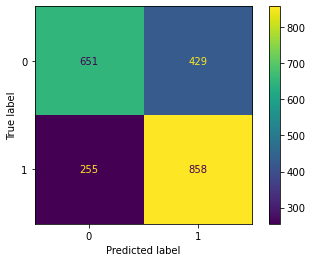

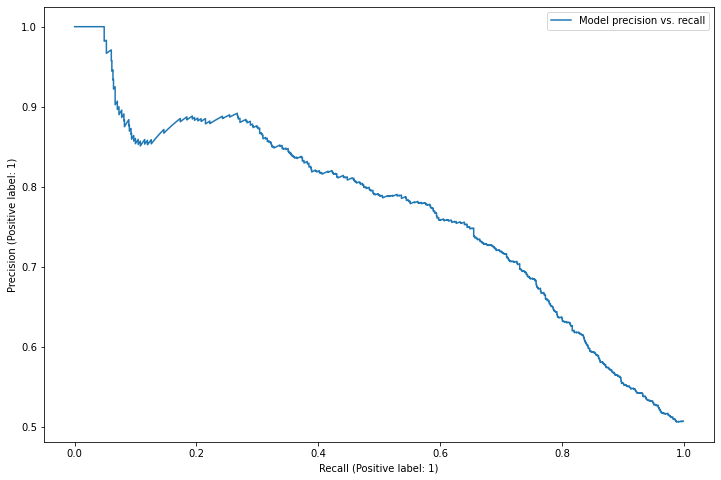

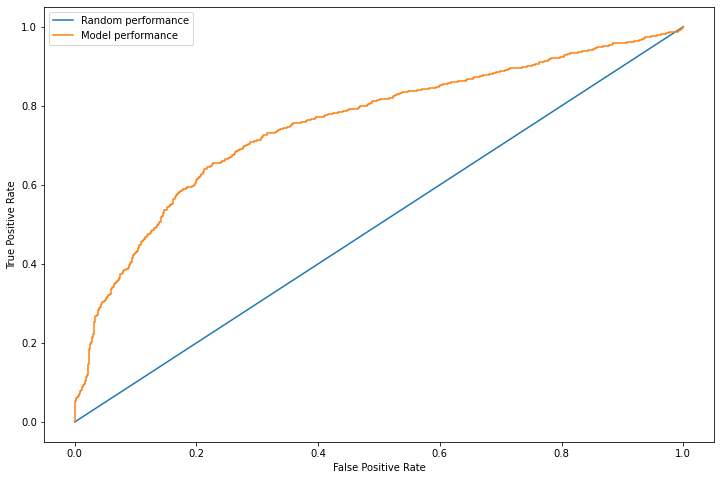

In [18]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [19]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Conv1D-undersampling' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Conv1D-undersampling20210602-1315


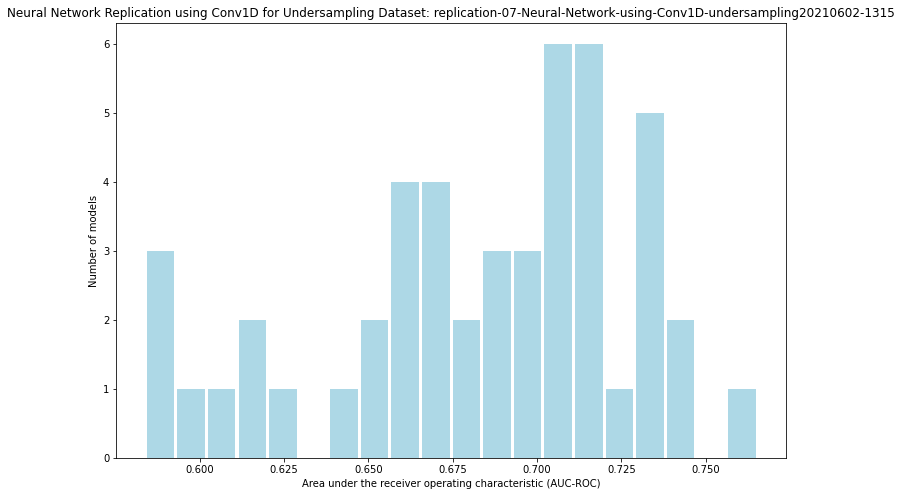

In [20]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Conv1D for Undersampling Dataset: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [21]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../DeepLearningResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)